In [1]:
from astroquery.gaia import Gaia
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.integrate import simpson
from astropy.coordinates import SkyCoord
from astropy.stats import histogram
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as ticker
import sys
sys.path.append("C:\\Users\\Anthony\\ezpadova")
from ezpadova import parsec
from scipy.optimize import minimize
from scipy.interpolate import interp1d

%matplotlib inline
np.seterr(all='ignore');

In [2]:
#first query
query = """SELECT 
source_id, ra, ra_error, dec, dec_error, parallax, parallax_error, pmra, pmra_error, pmdec, pmdec_error
FROM gaiadr3.gaia_source
WHERE parallax > 0 AND ra_error < 1 AND dec_error < 1 AND pmra_error < 1 AND pmdec_error < 1 AND parallax_error < 1 AND
1=CONTAINS(
  POINT(ra, dec),
  BOX(11.7958, 85.2439, 16.12067, 1.330735))
"""

job = Gaia.launch_job_async(query)
results = job.get_results()
results_df = results.to_pandas()

INFO: Query finished. [astroquery.utils.tap.core]


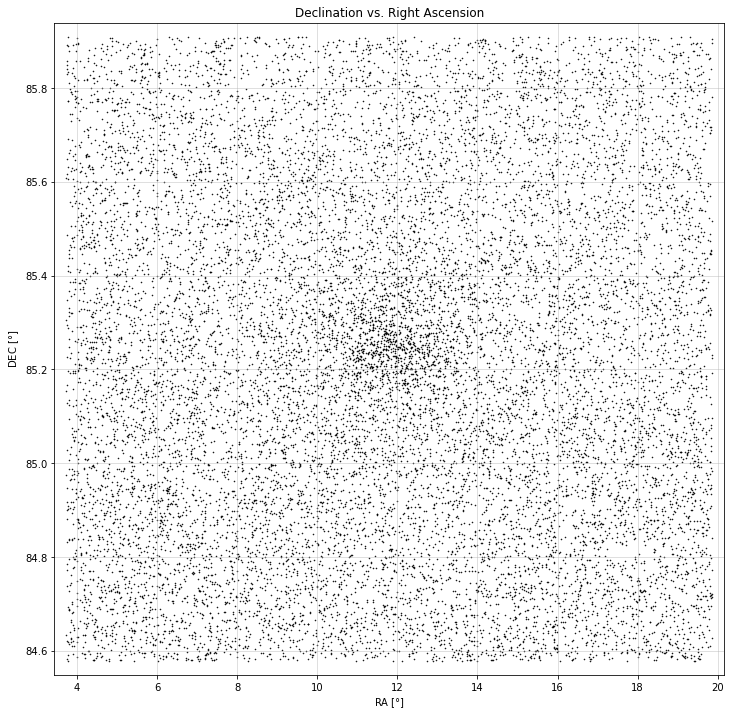

In [3]:
#RA DEC------------------------------------------------------------------------------------------------
#plotting dec vs ra
plt.figure(figsize = (12,12))
plt.scatter(results_df['ra'], results_df['dec'], s = 0.3, color = 'k')
plt.xlabel(r'RA $[\degree]$')
plt.ylabel(r'DEC $[\degree]$')
plt.title('Declination vs. Right Ascension')
plt.xlim(min(results_df['ra'])-0.3, max(results_df['ra'])+0.3)
plt.ylim(min(results_df['dec'])-0.03, max(results_df['dec'])+0.03)
plt.grid(alpha = 0.5)

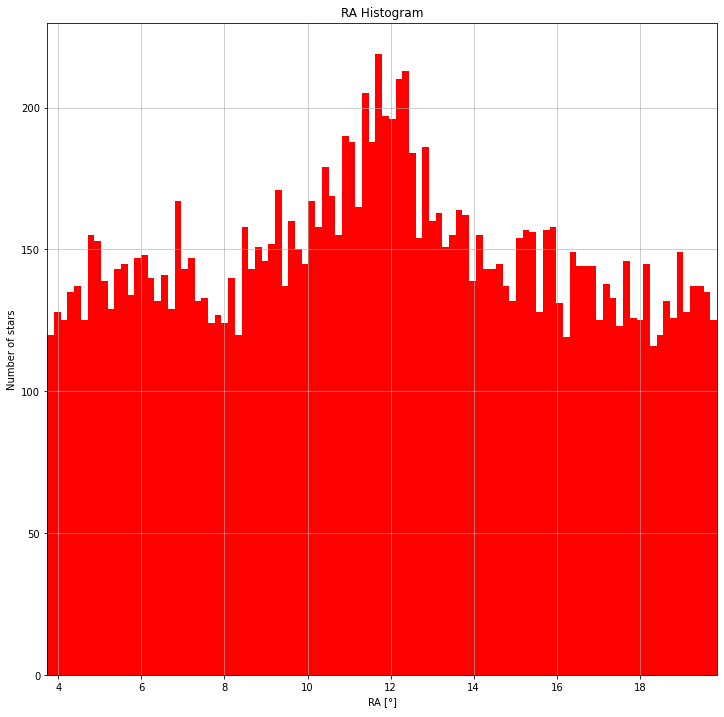

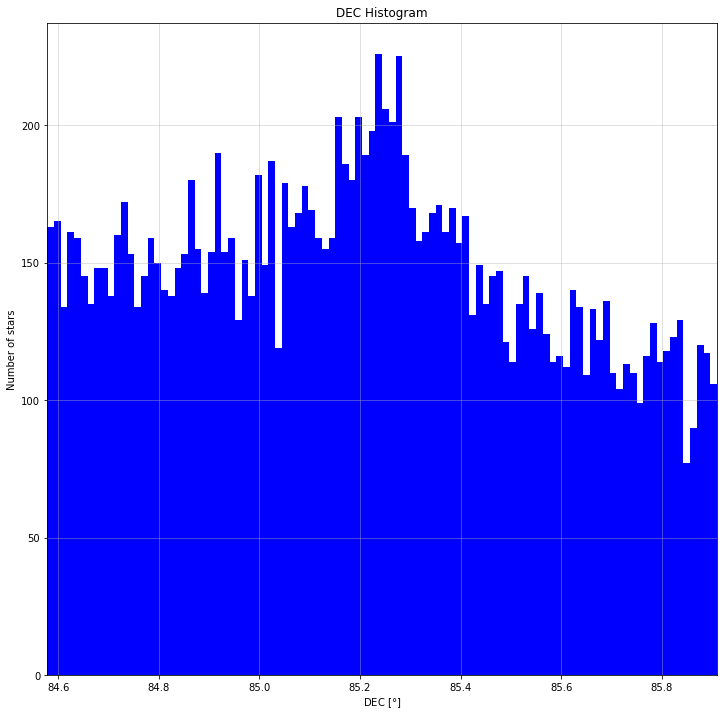

In [4]:
#getting rid of some indices that we'll want to get rid of early. doing this now so data in
#this plot is consistent with later plots
index = results_df[((1 / (results_df['parallax'] * 0.001)) > 12500)].index
results_df.drop(index, inplace = True)
index = results_df[(results_df['pmra'] > 20)].index
results_df.drop(index, inplace = True)
index = results_df[(results_df['pmra'] < -20)].index
results_df.drop(index, inplace = True)
index = results_df[(results_df['pmdec'] > 20)].index
results_df.drop(index, inplace = True)
index = results_df[(results_df['pmdec'] < -20)].index
results_df.drop(index, inplace = True)

#defining our data, bins
ras = results_df['ra']
decs = results_df['dec']
numbins_radec = 100

#plotting
plt.figure(0, figsize = (12,12))
plt.hist(ras, bins = numbins_radec, color = 'r')
plt.title('RA Histogram')
plt.xlabel(r'RA $[\degree]$')
plt.ylabel('Number of stars')
plt.xlim(min(ras), max(ras))
plt.grid(alpha = 0.75)

plt.figure(1, figsize = (12,12))
plt.hist(decs, bins = numbins_radec, color = 'b')
plt.title('DEC Histogram')
plt.xlabel(r'DEC $[\degree]$')
plt.ylabel('Number of stars')
plt.xlim(min(decs), max(decs))
plt.grid(alpha = 0.5)

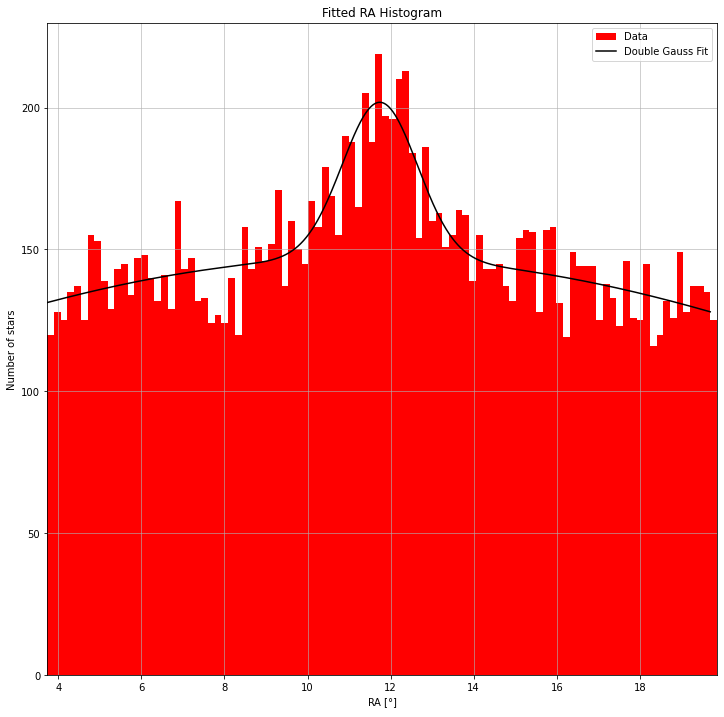

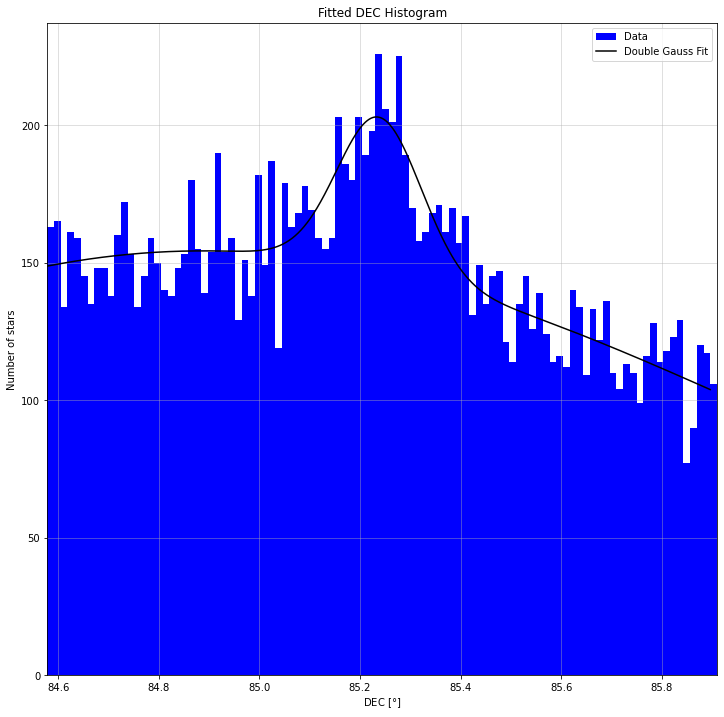

In [5]:
#making hists for ra and dec
rahist, rabins = np.histogram(ras, bins = numbins_radec)
dechist, decbins = np.histogram(decs, bins = numbins_radec)

#fixing some index issues
rahist, rabins = rahist[:numbins_radec], rabins[:numbins_radec]
dechist, decbins = dechist[:numbins_radec], decbins[:numbins_radec]

#double gauss function for fitting
def dublgauss(x, a, x0, sigma, a2, x02, sigma2):   
    return (a*np.exp(-(((x-x0)**2)/(2*(sigma**2))))) + (a2*np.exp(-(((x-x02)**2)/(2*(sigma2**2)))))

#fitting ra and dec hists with double gauss
poptra, pcovra = curve_fit(dublgauss, rabins, rahist, maxfev = 100000, p0 = (60, 12, 2, 20, 12, 0.1))
poptdec, pcovdec = curve_fit(dublgauss, decbins, dechist, maxfev = 100000, p0 = (60, 85.3, 2, 80, 85.3, 0.1))

#defining some more continuous data with our model parameters for plotting
ramodel_x_data = np.linspace(min(rabins), max(rabins), 10000)
ramodel_y_data = dublgauss(ramodel_x_data, * poptra)
decmodel_x_data = np.linspace(min(decbins), max(decbins), 10000)
decmodel_y_data = dublgauss(decmodel_x_data, * poptdec)

#plotting
plt.figure(0, figsize = (12,12))
plt.hist(ras, bins = numbins_radec, color = 'r', label = 'Data')
plt.plot(ramodel_x_data, ramodel_y_data, label = 'Double Gauss Fit', color = 'k')
plt.title('Fitted RA Histogram')
plt.xlabel(r'RA $[\degree]$')
plt.ylabel('Number of stars')
plt.xlim(min(ras), max(ras))
plt.legend()
plt.grid(alpha = 0.75)

plt.figure(1, figsize = (12,12))
plt.hist(decs, bins = numbins_radec, color = 'b', label = 'Data')
plt.plot(decmodel_x_data, decmodel_y_data, label = 'Double Gauss Fit', color = 'k')
plt.title('Fitted DEC Histogram')
plt.xlabel(r'DEC $[\degree]$')
plt.ylabel('Number of stars')
plt.xlim(min(decs), max(decs))
plt.legend()
plt.grid(alpha = 0.5)

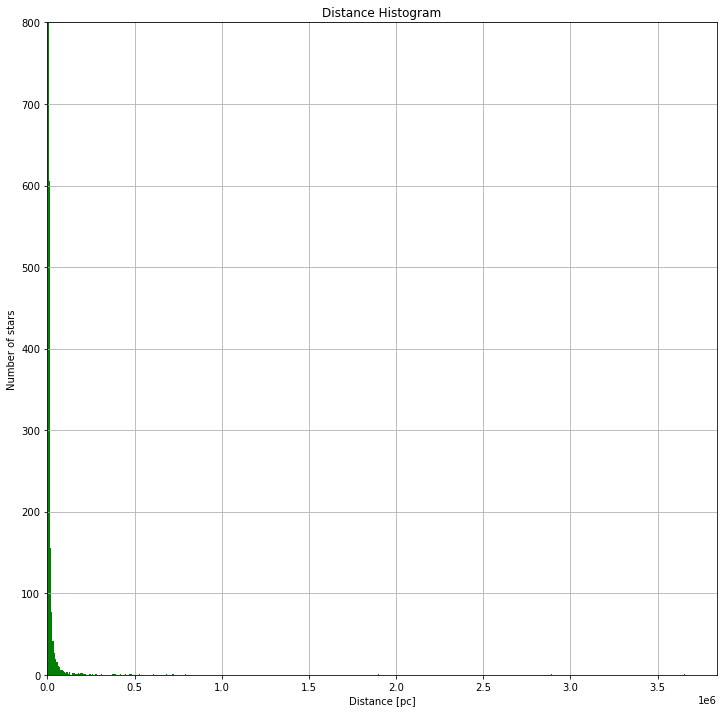

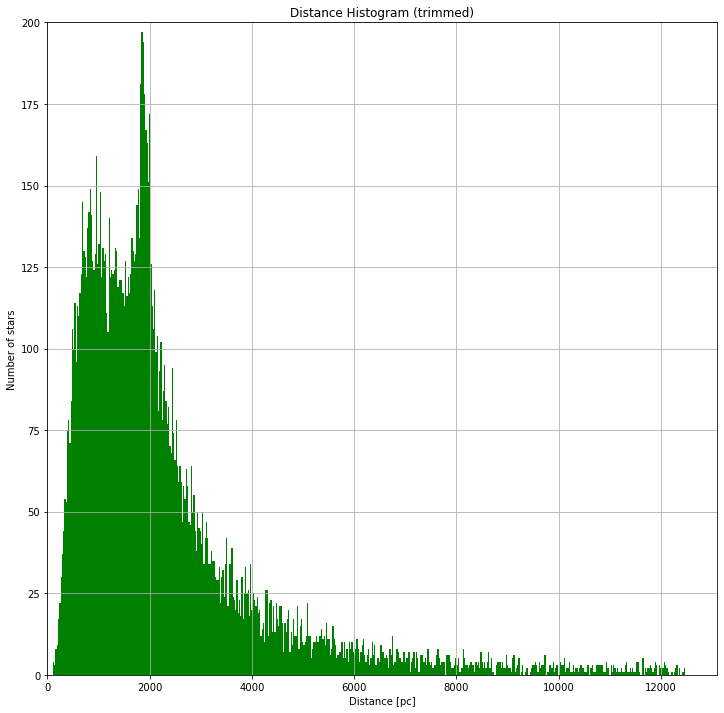

In [6]:
#DISTANCE-----------------------------------------------------------------------------------------------
#redefining our results dataframe, putting all that bad data back in that we removed earlier
#we do this because we want to show exactly why we removed such data in the first place
results_df = results.to_pandas()

#converting from plx to dist, defining bins
parallax_in_arcsec = results_df['parallax'] * 0.001
distances = 1/parallax_in_arcsec
numbins_dist = 500

#plotting
plt.figure(0, figsize = (12,12))
plt.hist(distances, bins = numbins_dist, color = 'g')
plt.title('Distance Histogram')
plt.xlabel('Distance [pc]')
plt.ylabel('Number of stars')
plt.ylim(0, 800)
plt.xlim(0)
plt.grid()

#getting rid of that bad data again, redefining our distance with bad data removed
index = results_df[((1 / (results_df['parallax'] * 0.001)) > 12500)].index
results_df.drop(index, inplace = True)
index = results_df[(results_df['pmra'] > 20)].index
results_df.drop(index, inplace = True)
index = results_df[(results_df['pmra'] < -20)].index
results_df.drop(index, inplace = True)
index = results_df[(results_df['pmdec'] > 20)].index
results_df.drop(index, inplace = True)
index = results_df[(results_df['pmdec'] < -20)].index
results_df.drop(index, inplace = True)
parallax_in_arcsec = results_df['parallax'] * 0.001
distances = 1/parallax_in_arcsec

#re-plotting with bad data removed
plt.figure(1, figsize = (12,12))
plt.hist(distances, bins = numbins_dist, color = 'g')
plt.title('Distance Histogram (trimmed)')
plt.xlabel('Distance [pc]')
plt.ylabel('Number of stars')
plt.xlim(0)
plt.ylim(0, 200)
plt.grid()

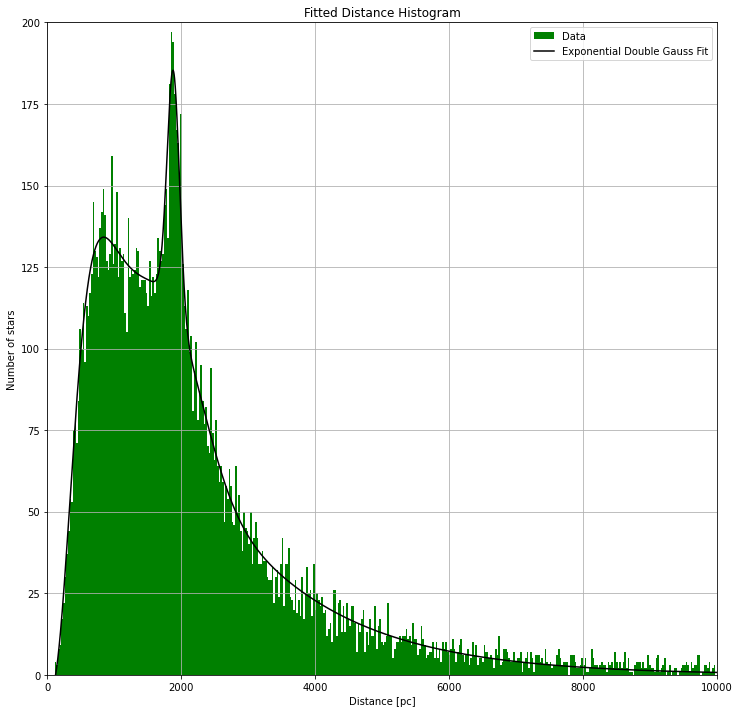

In [7]:
#defining a function to fit the distance histogram
def my_custom_function(x, a, b, c, a2, b2, c2, c3, k, d):   
    return (a * np.exp((-1/c)*(x-b)**2)) + (a2 * np.exp((-1/c2)*(x-b2)**2)) - (k * np.exp((-1/c3)*x**2)) + (k * np.exp(d * x))

#creating a distance histogram, fixing index error
disthist, distbins = np.histogram(distances, bins = numbins_dist)
disthist, distbins = disthist[:numbins_dist], distbins[:numbins_dist]

#fitting our parameters
poptdist, pcovdist = curve_fit(my_custom_function, distbins, disthist, maxfev = 100000,
                              p0 = (31, 950, 120000, 55.7, 2000, 200000, 100000, 20, -0.00025))

#making more continuous data for plotting
distmodel_x_data = np.linspace(min(distbins), max(distbins), 10000)
distmodel_y_data = my_custom_function(distmodel_x_data, *poptdist)

#plotting
plt.figure(figsize = (12,12))
plt.hist(distances, bins = numbins_dist, color = 'g', label = 'Data')
plt.plot(distmodel_x_data, distmodel_y_data, label = 'Exponential Double Gauss Fit', color = 'k')
plt.xlim(0, 10000)
plt.ylim(0, 200)
plt.title('Fitted Distance Histogram')
plt.xlabel('Distance [pc]')
plt.ylabel('Number of stars')
plt.legend()
plt.grid()

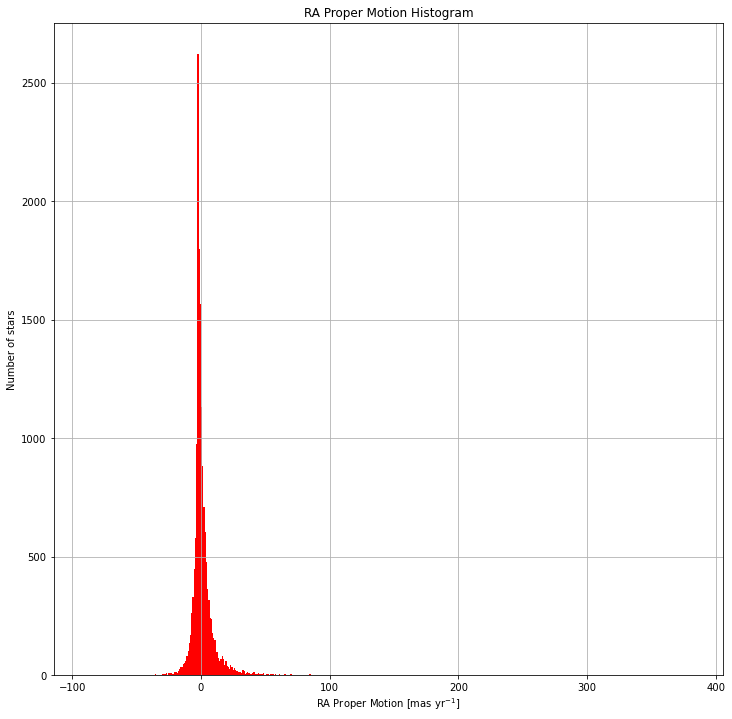

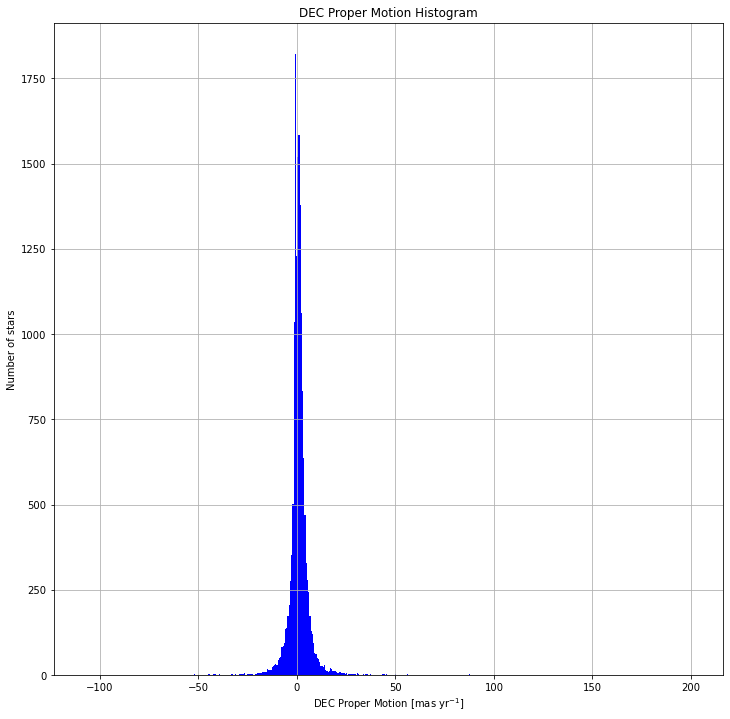

In [8]:
#PM---------------------------------------------------------------------------------------------------------
#again, redefining our results dataframe to show why we removed the bad data
results_df = results.to_pandas()

#defining pm ra, pm dec, bins
pm_ra = results_df['pmra']
pm_dec = results_df['pmdec']
numbins_pm = 500

#plotting
plt.figure(0, figsize = (12,12))
plt.hist(pm_ra, bins = numbins_pm, color = 'r')
plt.title('RA Proper Motion Histogram')
plt.xlabel('RA Proper Motion [mas yr$^{-1}$]')
plt.ylabel('Number of stars')
plt.grid()

plt.figure(1, figsize = (12,12))
plt.hist(pm_dec, bins = numbins_pm, color = 'b')
plt.title('DEC Proper Motion Histogram')
plt.xlabel('DEC Proper Motion [mas yr$^{-1}$]')
plt.ylabel('Number of stars')
plt.grid()

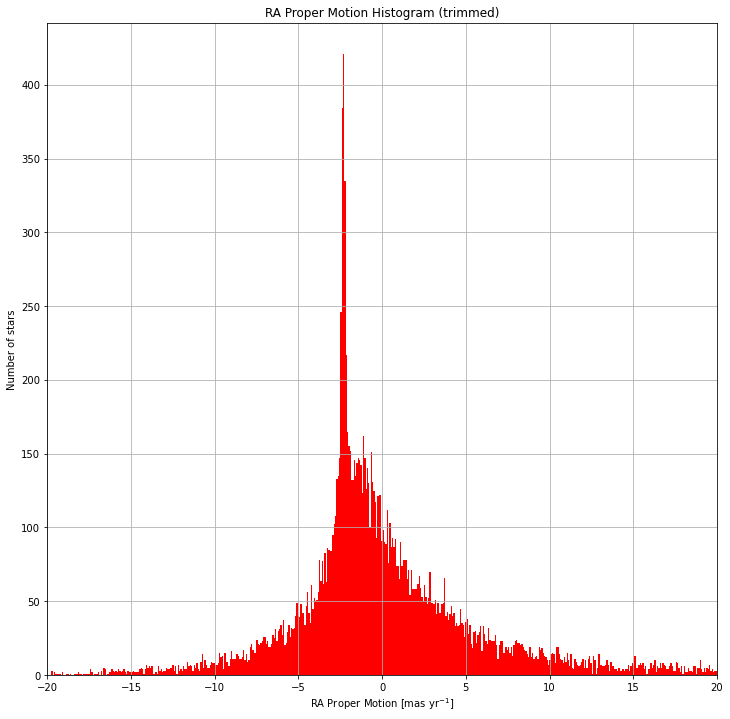

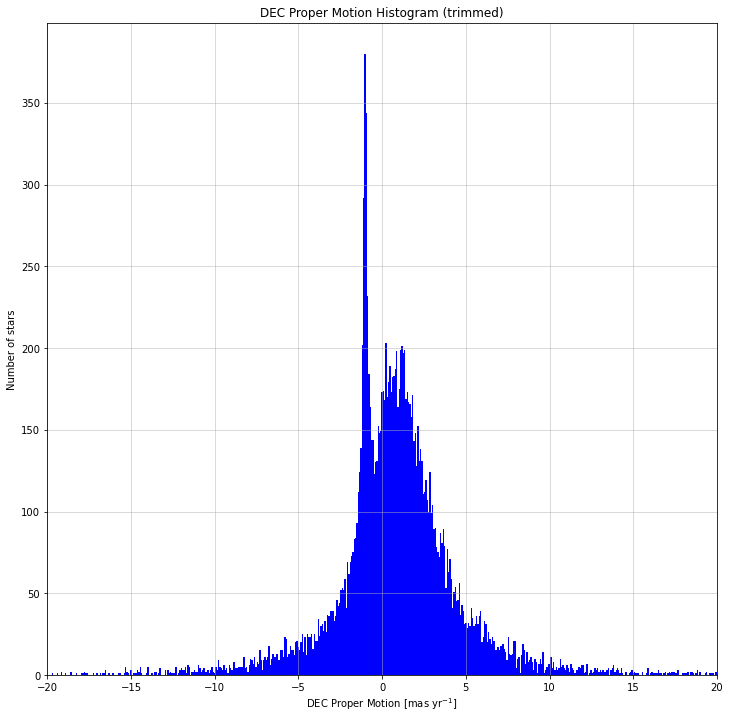

In [9]:
#removing bad data
index = results_df[((1 / (results_df['parallax'] * 0.001)) > 12500)].index
results_df.drop(index, inplace = True)
index = results_df[(results_df['pmra'] > 20)].index
results_df.drop(index, inplace = True)
index = results_df[(results_df['pmra'] < -20)].index
results_df.drop(index, inplace = True)
index = results_df[(results_df['pmdec'] > 20)].index
results_df.drop(index, inplace = True)
index = results_df[(results_df['pmdec'] < -20)].index
results_df.drop(index, inplace = True)

#redefining data, plotting again with bad data removed
pm_ra = results_df['pmra']
pm_dec = results_df['pmdec']

plt.figure(0, figsize = (12,12))
plt.hist(pm_ra, bins = numbins_pm, color = 'r')
plt.title('RA Proper Motion Histogram (trimmed)')
plt.xlabel('RA Proper Motion [mas yr$^{-1}$]')
plt.ylabel('Number of stars')
plt.xlim(-20, 20)
plt.grid()

plt.figure(1, figsize = (12,12))
plt.hist(pm_dec, bins = numbins_pm, color = 'b')
plt.title('DEC Proper Motion Histogram (trimmed)')
plt.xlabel('DEC Proper Motion [mas yr$^{-1}$]')
plt.ylabel('Number of stars')
plt.xlim(-20, 20)
plt.grid(alpha = 0.6)

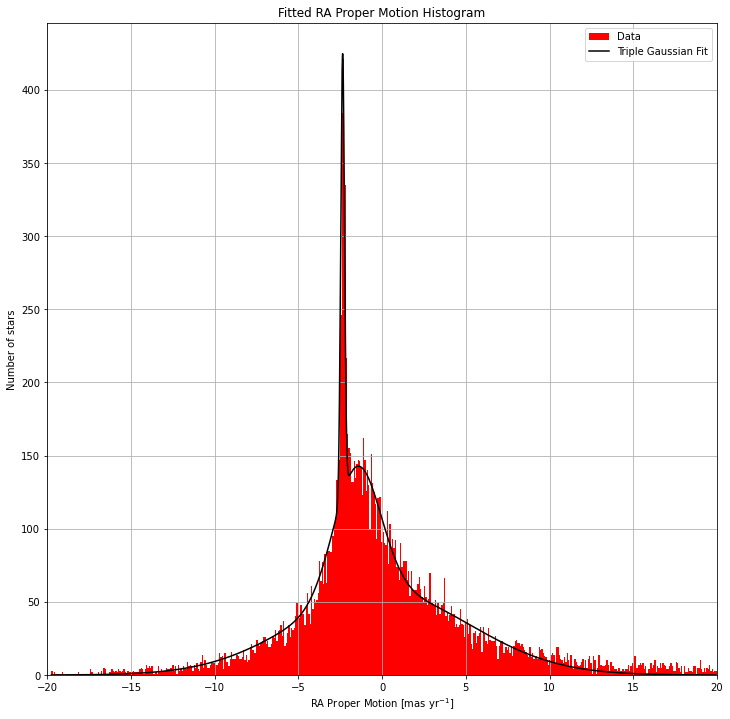

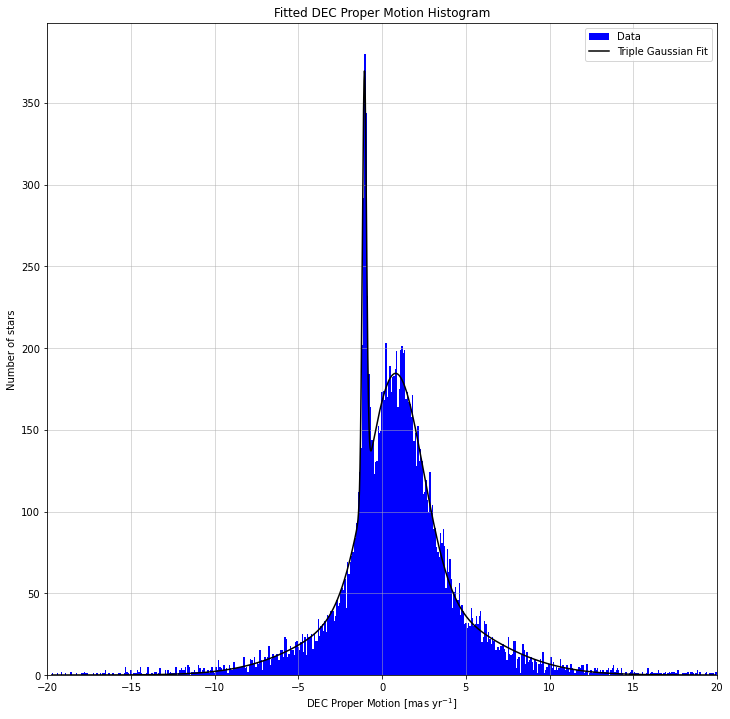

In [10]:
#defining a triple gauss function for fitting
def triplgauss(x, a, x0, sigma, a2, x02, sigma2, a3, x03, sigma3):   
    return (a*np.exp(-(((x-x0)**2)/(2*(sigma**2))))) + (a2*np.exp(-(((x-x02)**2)/(2*(sigma2**2))))) + (a3*np.exp(-(((x-x03)**2)/(2*(sigma3**2)))))

#making histograms for pm data
pm_rahist, pm_rabins = np.histogram(pm_ra, bins = numbins_pm)
pm_rahist, pm_rabins = pm_rahist[:numbins_pm], pm_rabins[:numbins_pm]
pm_dechist, pm_decbins = np.histogram(pm_dec, bins = numbins_pm)
pm_dechist, pm_decbins = pm_dechist[:numbins_pm], pm_decbins[:numbins_pm]

#fitting pm ra
poptpm_ra, pcovpm_ra = curve_fit(triplgauss, pm_rabins, pm_rahist, maxfev = 100000,
                                p0 = (150, -1, 3, 360, -2, 1, 10, -1, 10),
                                bounds = ((0, -2, -np.inf, 200, -3, -np.inf, 0, -2, -np.inf),
                                          (np.inf, 0, np.inf, np.inf, -1, np.inf, np.inf, 0, np.inf)))
#fitting pm dec
poptpm_dec, pcovpm_dec = curve_fit(triplgauss, pm_decbins, pm_dechist, maxfev = 100000,
                                  p0 = (200, 1, 3, 300, -1, 0.1, 10, -1, 10))

#more continuous data for plotting
pm_ramodel_x_data = np.linspace(min(pm_rabins), max(pm_rabins), 10000)
pm_ramodel_y_data = triplgauss(pm_ramodel_x_data, *poptpm_ra)
pm_decmodel_x_data = np.linspace(min(pm_decbins), max(pm_decbins), 10000)
pm_decmodel_y_data = triplgauss(pm_decmodel_x_data, *poptpm_dec)

#plotting
plt.figure(0, figsize = (12,12))
plt.hist(pm_ra, bins = numbins_pm, color = 'r', label = 'Data')
plt.plot(pm_ramodel_x_data, pm_ramodel_y_data, label = 'Triple Gaussian Fit', color = 'k')
plt.xlim(-20, 20)
plt.title('Fitted RA Proper Motion Histogram')
plt.xlabel('RA Proper Motion [mas yr$^{-1}$]')
plt.ylabel('Number of stars')
plt.legend()
plt.grid()

plt.figure(1, figsize = (12,12))
plt.hist(pm_dec, bins = numbins_pm, color = 'b', label = 'Data')
plt.plot(pm_decmodel_x_data, pm_decmodel_y_data, label = 'Triple Gaussian Fit', color = 'k')
plt.xlim(-20, 20)
plt.title('Fitted DEC Proper Motion Histogram')
plt.xlabel('DEC Proper Motion [mas yr$^{-1}$]')
plt.ylabel('Number of stars')
plt.legend()
plt.grid(alpha = 0.6)

In [11]:
#printing some results to check everything
center_ra = poptra[4]
center_dec = poptdec[4]
print('Best center position is (RA, DEC) = ({ra:.4f}, {dec:.4f}) deg'.format(ra = center_ra, dec = center_dec))

dist_to_cluster = poptdist[4]
print('Center distance is {:.2f} pc'.format(dist_to_cluster))

best_pm_ra = poptpm_ra[4]
best_pm_dec = poptpm_dec[4]
print('Best proper motion in RA, DEC is = ({pm_ra:.2f}, {pm_dec:.2f}) mas/yr'.format(pm_ra = best_pm_ra, pm_dec = best_pm_dec))

best_vd_ra = poptpm_ra[5]
best_vd_dec = poptpm_dec[5]
print('Best velocity dispersion in RA, DEC is = ({vd_ra:.2f}, {vd_dec:.2f}) mas/yr'.format(vd_ra = best_vd_ra, vd_dec = best_vd_dec))

Best center position is (RA, DEC) = (11.7424, 85.2376) deg
Center distance is 1881.15 pc
Best proper motion in RA, DEC is = (-2.36, -1.06) mas/yr
Best velocity dispersion in RA, DEC is = (0.11, 0.13) mas/yr


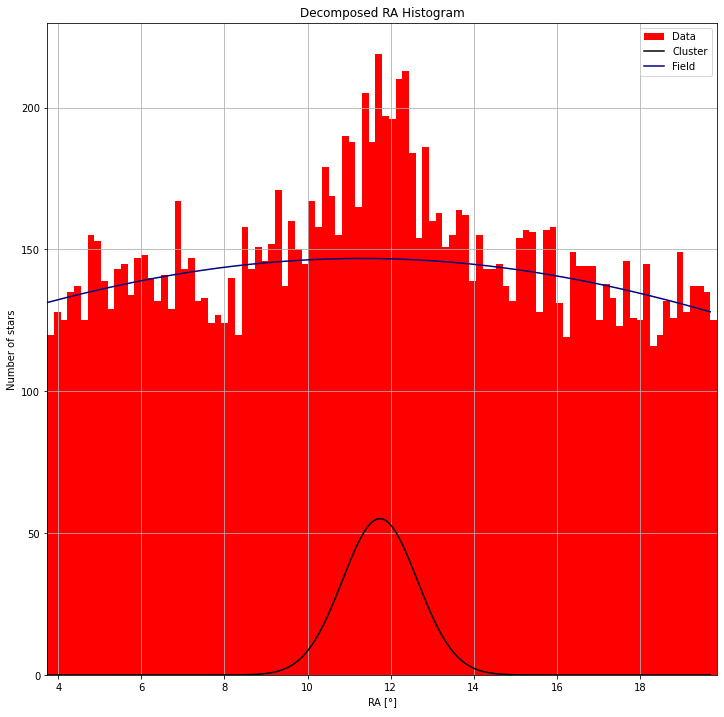

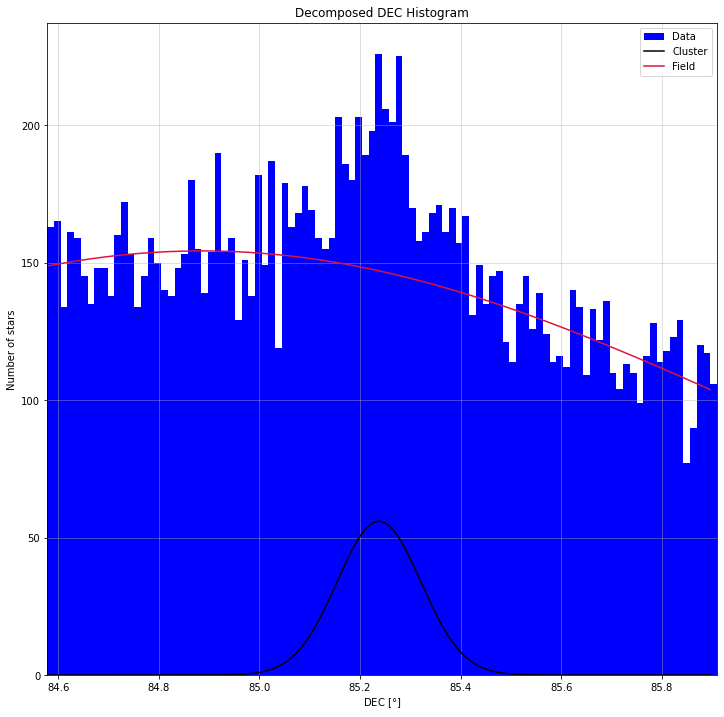

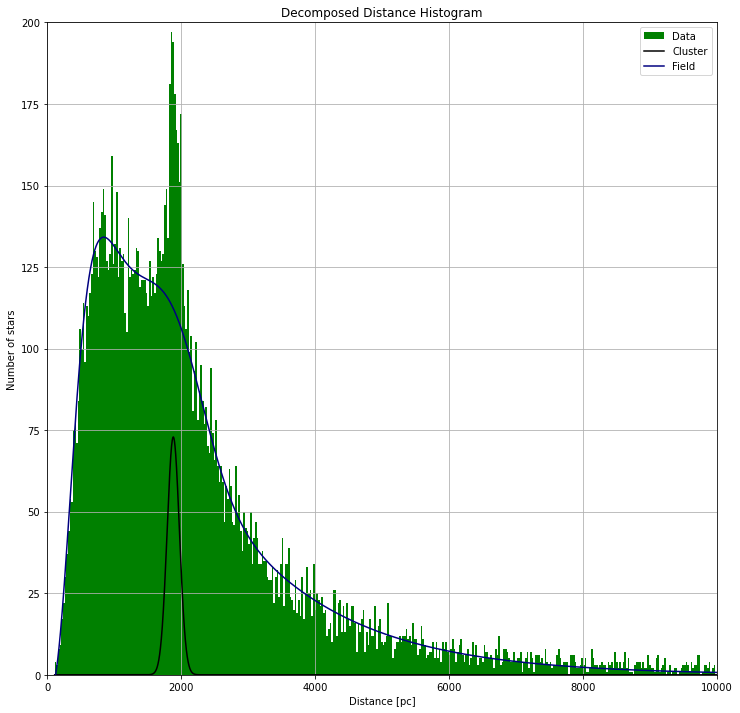

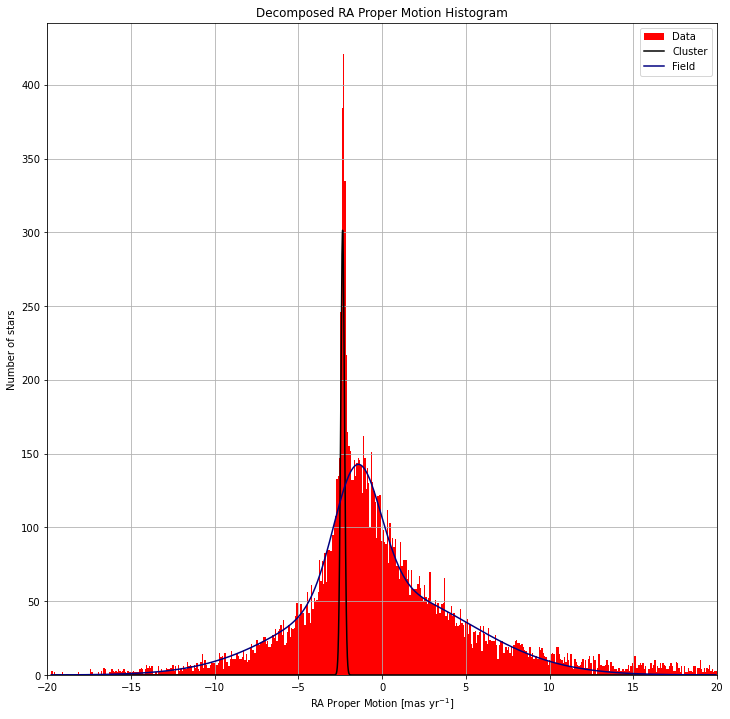

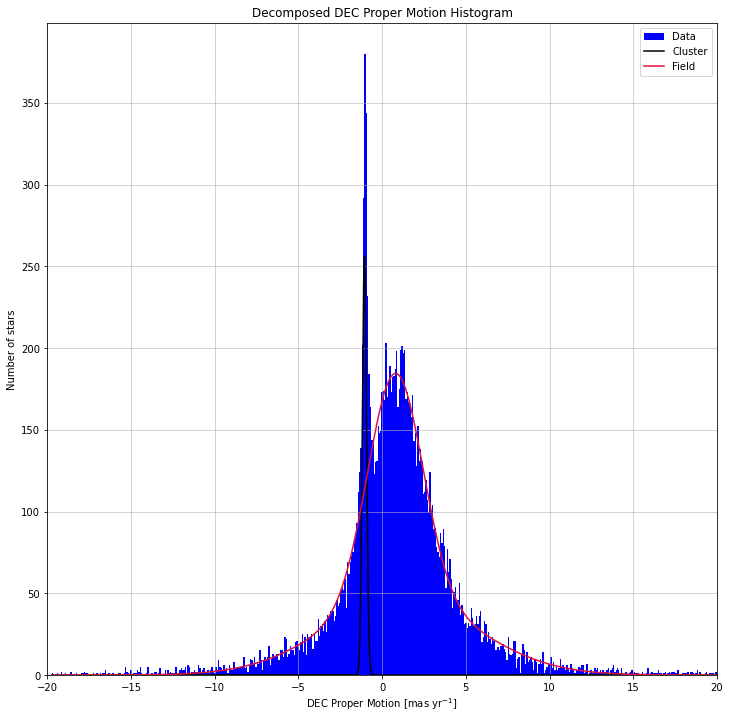

In [12]:
#PROBABILITIES--------------------------------------------------------------------------------------------
#separating cluster data from field data by separating our intentional cluster components
#of our models from our intentional field components
poptra_cluster = poptra.copy()
poptra_cluster[0] = 0
poptra_field = poptra.copy()
poptra_field[3] = 0
poptdec_cluster = poptdec.copy()
poptdec_cluster[0] = 0
poptdec_field = poptdec.copy()
poptdec_field[3] = 0
poptdist_cluster = poptdist.copy()
poptdist_cluster[0] = 0
poptdist_cluster[7] = 0
poptdist_field = poptdist.copy()
poptdist_field[3] = 0
poptpm_ra_cluster = poptpm_ra.copy()
poptpm_ra_cluster[0] = 0
poptpm_ra_cluster[6] = 0
poptpm_ra_field = poptpm_ra.copy()
poptpm_ra_field[3] = 0
poptpm_dec_cluster = poptpm_dec.copy()
poptpm_dec_cluster[0] = 0
poptpm_dec_cluster[6] = 0
poptpm_dec_field = poptpm_dec.copy()
poptpm_dec_field[3] = 0

#defining our new seperated fits
ra_y_c = dublgauss(ramodel_x_data, * poptra_cluster)
dec_y_c = dublgauss(decmodel_x_data, * poptdec_cluster)
ra_y_f = dublgauss(ramodel_x_data, * poptra_field)
dec_y_f = dublgauss(decmodel_x_data, * poptdec_field)
dist_y_c = my_custom_function(distmodel_x_data, *poptdist_cluster)
dist_y_f = my_custom_function(distmodel_x_data, *poptdist_field)
pmra_y_c = triplgauss(pm_ramodel_x_data, *poptpm_ra_cluster)
pmra_y_f = triplgauss(pm_ramodel_x_data, *poptpm_ra_field)
pmdec_y_c = triplgauss(pm_decmodel_x_data, *poptpm_dec_cluster)
pmdec_y_f = triplgauss(pm_decmodel_x_data, *poptpm_dec_field)

#plotting all of our data with their distinct field and cluster fits overlayed
plt.figure(0, figsize = (12,12))
plt.hist(ras, bins = numbins_radec, color = 'r', label = 'Data')
plt.plot(ramodel_x_data, ra_y_c, label = 'Cluster', color = 'k')
plt.plot(ramodel_x_data, ra_y_f, label = 'Field', color = 'navy')
plt.title('Decomposed RA Histogram')
plt.xlabel(r'RA $[\degree]$')
plt.ylabel('Number of stars')
plt.xlim(min(ras), max(ras))
plt.legend()
plt.grid()

plt.figure(1, figsize = (12,12))
plt.hist(decs, bins = numbins_radec, color = 'b', label = 'Data')
plt.plot(decmodel_x_data, dec_y_c, label = 'Cluster', color = 'k')
plt.plot(decmodel_x_data, dec_y_f, label = 'Field', color = 'crimson')
plt.title('Decomposed DEC Histogram')
plt.xlabel(r'DEC $[\degree]$')
plt.ylabel('Number of stars')
plt.xlim(min(decs), max(decs))
plt.legend()
plt.grid(alpha = 0.5)

plt.figure(2, figsize = (12,12))
plt.hist(distances, bins = numbins_dist, color = 'g', label = 'Data')
plt.plot(distmodel_x_data, dist_y_c, label = 'Cluster', color = 'k')
plt.plot(distmodel_x_data, dist_y_f, label = 'Field', color = 'navy')
plt.xlim(0, 10000)
plt.ylim(0, 200)
plt.title('Decomposed Distance Histogram')
plt.xlabel('Distance [pc]')
plt.ylabel('Number of stars')
plt.legend()
plt.grid()

plt.figure(3, figsize = (12,12))
plt.hist(pm_ra, bins = numbins_pm, color = 'r', label = 'Data')
plt.plot(pm_ramodel_x_data, pmra_y_c, label = 'Cluster', color = 'k')
plt.plot(pm_ramodel_x_data, pmra_y_f, label = 'Field', color = 'navy')
plt.title('Decomposed RA Proper Motion Histogram')
plt.xlim(-20, 20)
plt.xlabel('RA Proper Motion [mas yr$^{-1}$]')
plt.ylabel('Number of stars')
plt.legend()
plt.grid()

plt.figure(4, figsize = (12,12))
plt.hist(pm_dec, bins = numbins_pm, color = 'b', label = 'Data')
plt.plot(pm_decmodel_x_data, pmdec_y_c, label = 'Cluster', color = 'k')
plt.plot(pm_decmodel_x_data, pmdec_y_f, label = 'Field', color = 'crimson')
plt.title('Decomposed DEC Proper Motion Histogram')
plt.xlim(-20, 20)
plt.xlabel('DEC Proper Motion [mas yr$^{-1}$]')
plt.ylabel('Number of stars')
plt.legend()
plt.grid(alpha = 0.7)

NOTE: the reason the "P" value is so low is because, to discriminate between high likelihood cluster stars and field stars, 
I fine tuned the value until Nc_Nf_ratio_average (0.0646) and [len(goodra) / (len(badra))] (0.0647) were roughly average in
order to stay true to the method in which my Nc and Nf values were discovered. Because of this, we can see that my method is
returning a rather low probability (0.77)...


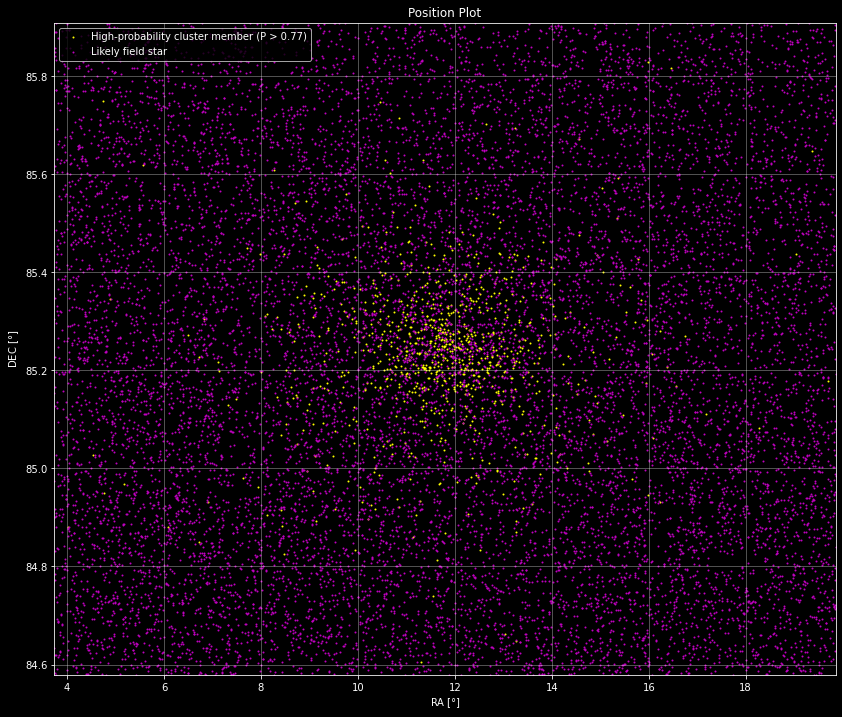

In [13]:
#defining some membership probability function parameters
sigmax, sigmay = best_vd_ra, best_vd_dec
muxc, muyc = best_pm_ra, best_pm_dec
muxf, muyf = poptpm_ra[1], poptpm_dec[1]
bigsigmax, bigsigmay = poptpm_ra[2], poptpm_dec[2]

#integrating through our distinct cluster fit and field fit models
dx = 0.00001
Nc_ra = simpson(ra_y_c, dx = dx)
Nc_dec = simpson(dec_y_c, dx = dx)
Nf_ra = simpson(ra_y_f, dx = dx)
Nf_dec = simpson(dec_y_f, dx = dx)
Nc_d = simpson(dist_y_c, dx = dx)
Nf_d = simpson(dist_y_f, dx = dx)
Nc_ra_pm = simpson(pmra_y_c, dx = dx)
Nc_dec_pm = simpson(pmdec_y_c, dx = dx)
Nf_ra_pm = simpson(pmra_y_f, dx = dx)
Nf_dec_pm = simpson(pmdec_y_f, dx = dx)

#using our integration results to define ratios of Nc:Nf for each type of data (e.g., ra, pm ra, distance, etc.)
Nc_Nf_ratio_ra = Nc_ra / Nf_ra
Nc_Nf_ratio_dec = Nc_dec / Nf_dec
Nc_Nf_ratio_d = Nc_d / Nf_d
Nc_Nf_ratio_pmra = Nc_ra_pm / Nf_ra_pm
Nc_Nf_ratio_pmdec = Nc_dec_pm / Nf_dec_pm

#taking an average of the previous ratios for a master average
Nc_Nf_ratio_average = (Nc_Nf_ratio_ra + Nc_Nf_ratio_dec + Nc_Nf_ratio_d + Nc_Nf_ratio_pmra + Nc_Nf_ratio_pmdec) / 5

#defining our total stars as the known number of stars in the data we're using
total_stars = len(results_df)

#using our known total number of stars and our ratios to define Nc and Nf
Nc = total_stars * Nc_Nf_ratio_average
Nf = total_stars - Nc

#defining our membership probability functions
def phiC(mux, muy):
    return (Nc / (2 * np.pi * sigmax * sigmay)) * np.exp(-((((mux - muxc)**2) / (2 * sigmax**2)) + (((muy - muyc)**2) / (2 * sigmay**2))))    
def phif(mux, muy):
    return (Nf / (2 * np.pi * bigsigmax * bigsigmay)) * np.exp(-((((mux - muxf)**2) / (2 * bigsigmax**2)) + (((muy - muyf)**2) / (2 * bigsigmay**2))))

#using our functions and parameters to get an array of membership probabilities
probs = np.array([])
for i in range(len(results_df)):
    phi_c = phiC(results_df['pmra'].values[i], results_df['pmdec'].values[i])
    phi_f = phif(results_df['pmra'].values[i], results_df['pmdec'].values[i])
    prob = phi_c / (phi_f + phi_c)
    probs = np.append(probs, prob)

#switching our dataframe results to numpy arrays
objid, ra, ra_err, dec, dec_err, plx, plx_err, pmra, pmra_err, pmdec, pmdec_err = np.transpose(results_df.to_numpy())

#separating "good" data from "bad" data according to P = 0.77 to stay consistent to our Nc:Nf ratio
goodra = np.array([])
gooddec = np.array([])
goodpmra = np.array([])
goodpmdec = np.array([])
goodplx = np.array([])
goodra_err = np.array([])
gooddec_err = np.array([])
badra = np.array([])
baddec = np.array([])
badpmra = np.array([])
badpmdec = np.array([])
badplx = np.array([])
badra_err = np.array([])
baddec_err = np.array([])
for i in range(len(probs)):
    if probs[i] > 0.77:
        goodra = np.append(goodra, ra[i])
        gooddec = np.append(gooddec, dec[i])
        goodpmra = np.append(goodpmra, pmra[i])
        goodpmdec = np.append(goodpmdec, pmdec[i])
        goodplx = np.append(goodplx, plx[i])
        goodra_err = np.append(goodra_err, ra_err[i])
        gooddec_err = np.append(gooddec_err, dec_err[i])
    else:
        badra = np.append(badra, ra[i])
        baddec = np.append(baddec, dec[i])
        badpmra = np.append(badpmra, pmra[i])
        badpmdec = np.append(badpmdec, pmdec[i])
        badplx = np.append(badplx, plx[i])
        badra_err = np.append(badra_err, ra_err[i])
        baddec_err = np.append(baddec_err, dec_err[i])     

#plotting dec vs ra again, with high-probability cluster members highlighted
plt.style.use('dark_background')
plt.figure(figsize = (14,12))
plt.scatter(goodra, gooddec, s = 1, label = 'High-probability cluster member (P > 0.77)', color = 'yellow')
plt.scatter(badra, baddec, s = 1, label = 'Likely field star', color = 'm')
plt.title('Position Plot')
plt.xlabel(r'RA $[\degree]$')
plt.ylabel(r'DEC $[\degree]$')
plt.xlim(min(ra), max(ra))
plt.ylim(min(dec), max(dec))
plt.legend()
plt.grid(alpha = 0.4)

print('''NOTE: the reason the "P" value is so low is because, to discriminate between high likelihood cluster stars and field stars, 
I fine tuned the value until Nc_Nf_ratio_average ({ratio:.4f}) and [len(goodra) / (len(badra))] ({leng:.4f}) were roughly average in
order to stay true to the method in which my Nc and Nf values were discovered. Because of this, we can see that my method is
returning a rather low probability (0.77)...'''.format(ratio = Nc_Nf_ratio_average, leng = len(goodra) / len(badra)))

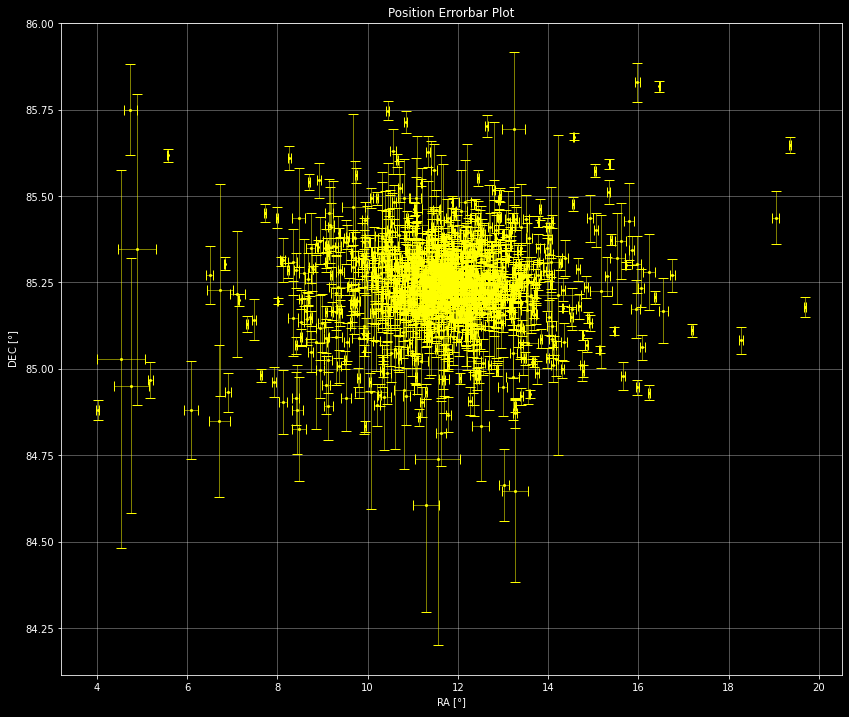

In [14]:
#I was just curious about the errorbars for this plot, especially for the stars farther from the center
#This plot is very ugly. Feel free to ignore.

#plotting with errorbars
plt.figure(figsize = (14,12))
plt.errorbar(goodra, gooddec, yerr = gooddec_err, xerr = goodra_err, fmt = 'o', color = 'yellow',
             label = 'High-probability cluster member (P > 0.77)', capsize = 5, elinewidth = 0.5, markersize = 2)
plt.title('Position Errorbar Plot')
plt.xlabel(r'RA $[\degree]$')
plt.ylabel(r'DEC $[\degree]$')
plt.grid(alpha = 0.4)

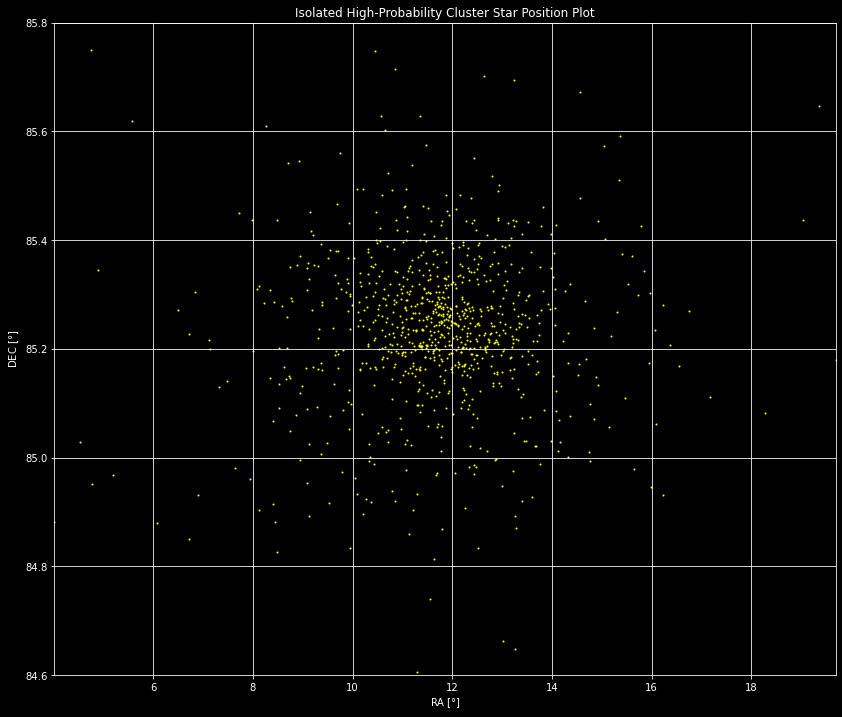

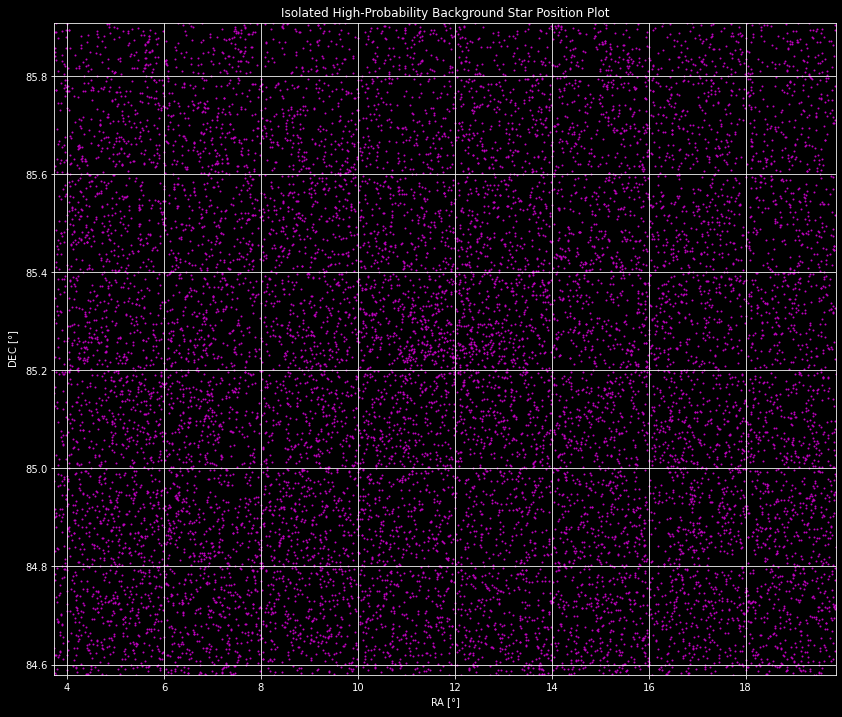

In [15]:
#plotting isolated likely cluster stars and likely field stars
plt.figure(0, figsize = (14,12))
plt.scatter(goodra, gooddec, s = 1, color = 'yellow')
plt.title('Isolated High-Probability Cluster Star Position Plot')
plt.xlabel(r'RA $[\degree]$')
plt.ylabel(r'DEC $[\degree]$')
plt.xlim(min(goodra), max(goodra))
plt.ylim(84.6, 85.8)
plt.grid()

plt.figure(1, figsize = (14,12))
plt.scatter(badra, baddec, s = 1, color = 'm')
plt.title('Isolated High-Probability Background Star Position Plot')
plt.xlabel(r'RA $[\degree]$')
plt.ylabel(r'DEC $[\degree]$')
plt.xlim(min(ra), max(ra))
plt.ylim(min(dec), max(dec))
plt.grid()

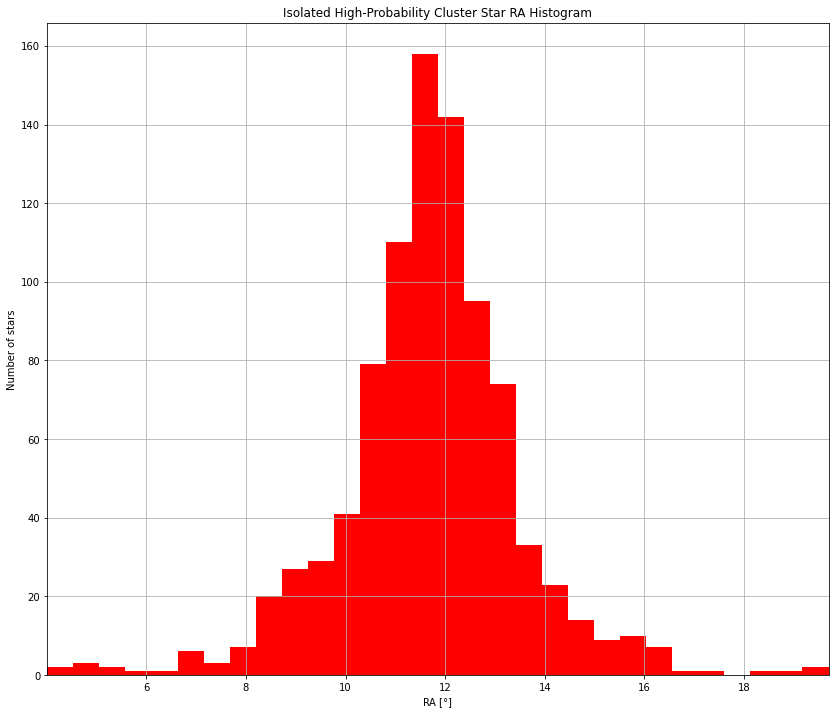

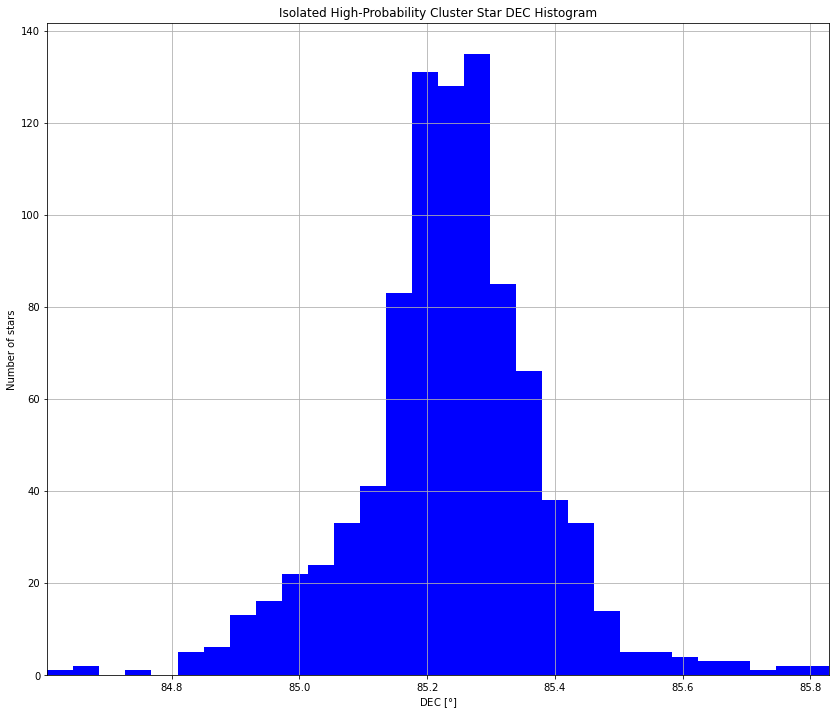

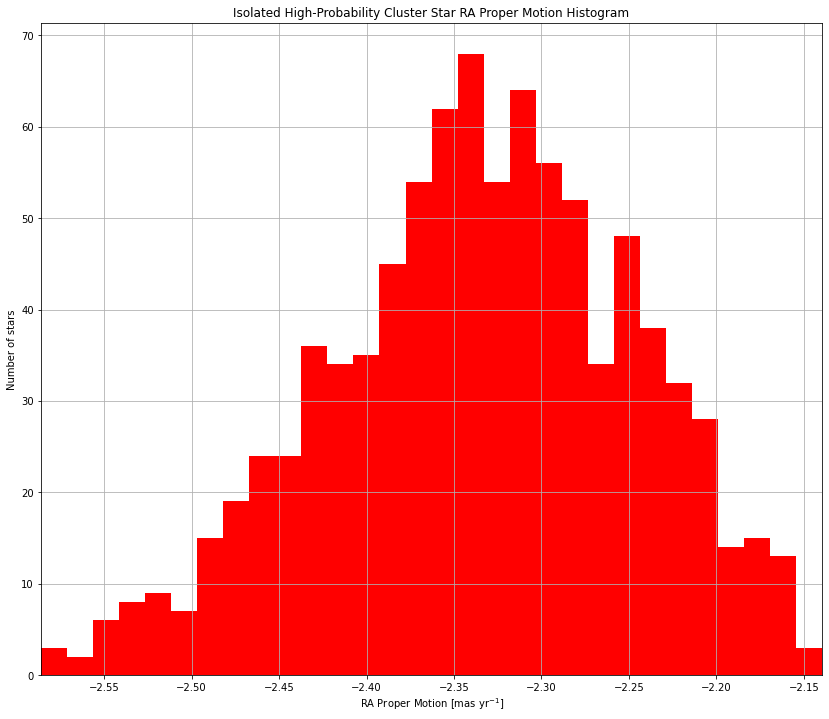

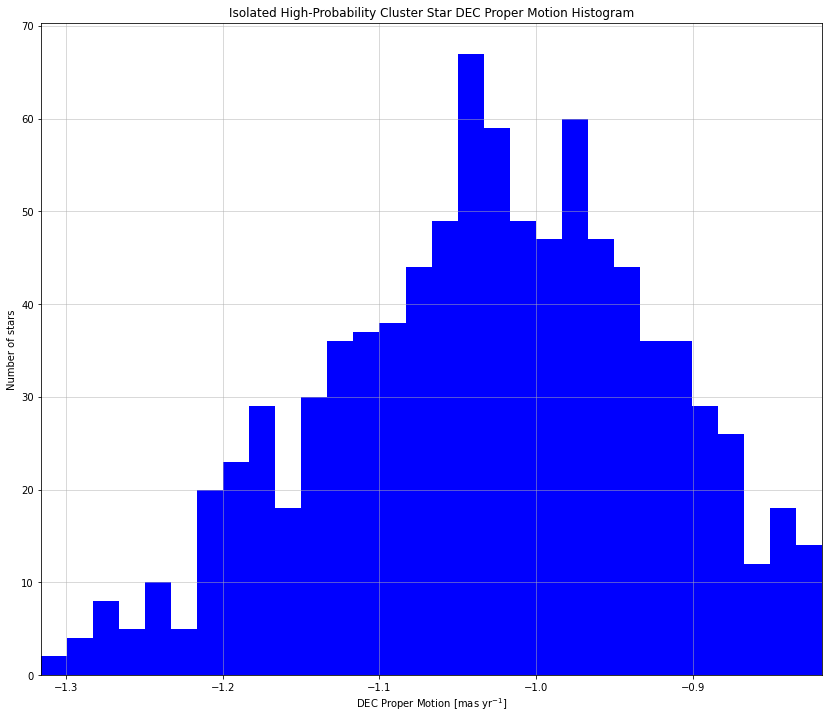

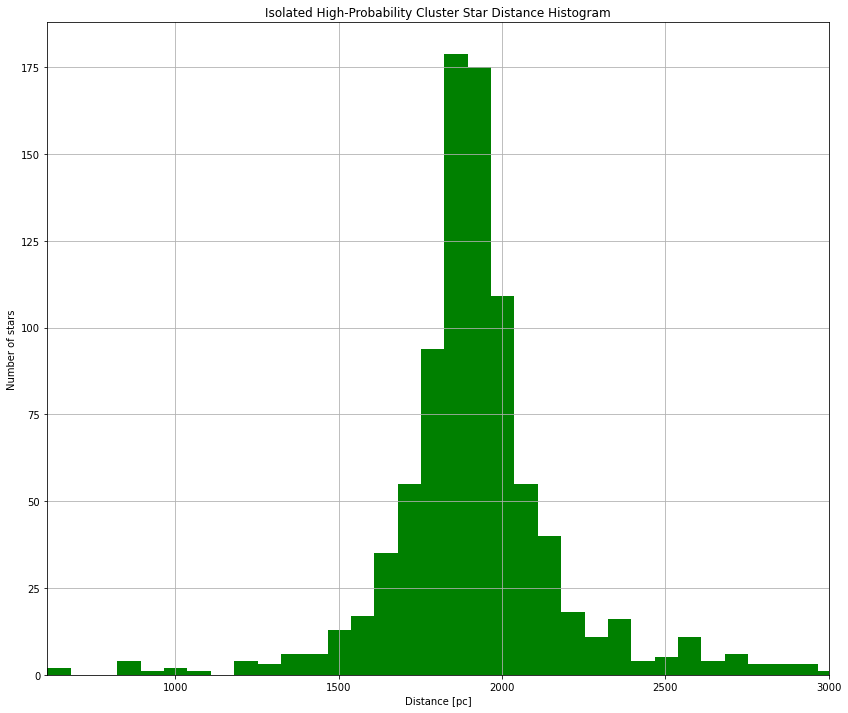

In [16]:
#Again, I was just curious: hoping to see these plots looking more like normal distributions, which they mostly do
#But feel free to ignore.
plt.style.use('default')
%matplotlib inline

#plotting new histograms for only cluster data to verify that they look normal
plt.figure(0, figsize = (14,12))
plt.title('Isolated High-Probability Cluster Star RA Histogram')
plt.hist(goodra, bins = 30, color = 'r')
plt.xlim(min(goodra), max(goodra))
plt.xlabel(r'RA $[\degree]$')
plt.ylabel('Number of stars')
plt.grid()

plt.figure(1, figsize = (14,12))
plt.title('Isolated High-Probability Cluster Star DEC Histogram')
plt.hist(gooddec, bins = 30, color = 'b')
plt.xlim(min(gooddec), max(gooddec))
plt.xlabel(r'DEC $[\degree]$')
plt.ylabel('Number of stars')
plt.grid()

plt.figure(2, figsize = (14,12))
plt.hist(goodpmra, bins = 30, color = 'r')
plt.title('Isolated High-Probability Cluster Star RA Proper Motion Histogram')
plt.xlim(min(goodpmra), max(goodpmra))
plt.xlabel('RA Proper Motion [mas yr$^{-1}$]')
plt.ylabel('Number of stars')
plt.grid()

plt.figure(3, figsize = (14,12))
plt.hist(goodpmdec, bins = 30, color = 'b')
plt.title('Isolated High-Probability Cluster Star DEC Proper Motion Histogram')
plt.xlim(min(goodpmdec), max(goodpmdec))
plt.xlabel('DEC Proper Motion [mas yr$^{-1}$]')
plt.ylabel('Number of stars')
plt.grid(alpha = 0.6)

good_d = 1 / (goodplx * 0.001)
plt.figure(4, figsize = (14,12))
plt.title('Isolated High-Probability Cluster Star Distance Histogram')
plt.hist(good_d, bins = 150, color = 'g')
plt.xlim(min(good_d), 3000)
plt.xlabel('Distance [pc]')
plt.ylabel('Number of stars')
plt.grid()

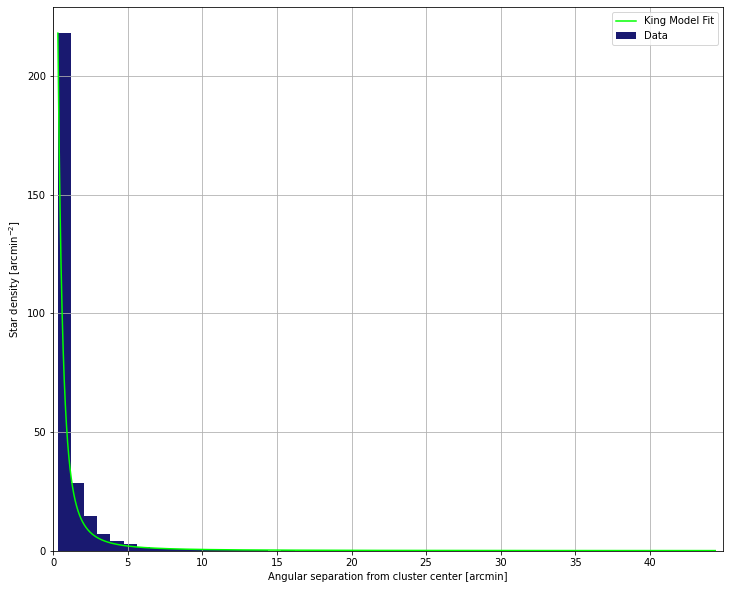

In [17]:
#KING MODEL------------------------------------------------------------------------------------------------------------
#using earlier determined parameters to define center coordinates of our cluster
centerC = SkyCoord('{}'.format(center_ra), '{}'.format(center_dec), unit = 'deg', frame = 'icrs')

#calculating angular separations from the center of the cluster, for each star
seps = []
for i in range(len(goodra)):
    ra = goodra[i]
    dec = gooddec[i]
    starC = SkyCoord('{}'.format(ra),'{}'.format(dec), unit = 'deg', frame = 'icrs')    
    sep = centerC.separation(starC)
    seps.append(sep)

#converting our separations to degrees
seps_arr = np.array([])
for i in range(len(seps)):
    sep = seps[i].deg
    seps_arr = np.append(seps_arr, sep)

#number of bins
rnumbins = 50

#making separation histograms, fixing index error
numstars_sep, degrees = np.histogram(seps_arr, bins = rnumbins)
numstars_sep, degrees = numstars_sep[:rnumbins], degrees[:rnumbins]

#defining star density (per degree2)
numstars_per_deg2 = numstars_sep / (degrees**2)

#changing degrees array to arcmins and defining star density (per arcmin2)
arcmin = degrees * 60
numstars_per_arcmin2 = numstars_per_deg2 / 3600

#defining our king model
def King(r, fbg, f0, rc):
    return fbg + (f0 / (1 + ((r / rc)**2)))

#fitting our king model to our histogram
poptsep, pcovsep = curve_fit(King, arcmin, numstars_per_arcmin2, maxfev = 100000)

#making more continuous data for plotting
sep_x_data = np.linspace(min(arcmin), max(arcmin), 10000)
sep_y_data = King(sep_x_data, *poptsep)

#plotting
plt.figure(figsize = (12,10))
plt.plot(sep_x_data, sep_y_data, label = 'King Model Fit', color = 'lime')
plt.hist(arcmin, bins = 50, weights = numstars_per_arcmin2, color = 'midnightblue', label = 'Data')
plt.xlabel('Angular separation from cluster center [arcmin]')
plt.ylabel(r'Star density $[\mathrm{arcmin}^{-2}]$')
plt.xlim(0, max(arcmin)+0.5)
plt.ylim(0)
plt.legend()
plt.grid()

In [18]:
#using our fit parameters to determine rlim and define our new search radius rlim * 1.1
f_bg, f_0, r_c = poptsep
perrsep = np.sqrt(np.diag(pcovsep))
sigma_bg = perrsep[0]

rlim = r_c * np.sqrt((f_0 / (3 * sigma_bg)) - 1)
print('rlim is {limit_r:.6f} arcmin'.format(limit_r = rlim))

newradius = 1.1 * rlim
print('so our new radius is {limit_r:.6f} arcmin'.format(limit_r = newradius))

newradius_degrees = newradius / 60
print('which is {finalradius:.6f} degrees'.format(finalradius = newradius_degrees))

rlim is 12.028515 arcmin
so our new radius is 13.231367 arcmin
which is 0.220523 degrees


In [19]:
#NEW GAIA SEARCH AND ANALYSIS---------------------------------------------------------------------------------------------------------

#Values above were found by dividing our values from query1 by the "intended" value of 40' (0.667 deg)
#They should be the "scaling factors" so to speak for the width and height between a cone and pyramid for our specific situation
#And they are, because I tested this with a circle query and it indeed covered the same amount of space
width_for_query = newradius_degrees * 24.181
height_for_query = newradius_degrees * 1.996

#new query
query2 = """SELECT 
source_id, ra, ra_error, dec, dec_error, parallax, parallax_error, pmra, pmra_error, pmdec, pmdec_error, phot_g_mean_mag, phot_rp_mean_mag
FROM gaiadr3.gaia_source
WHERE parallax > 0 AND ra_error < 1 AND dec_error < 1 AND pmra_error < 1 AND pmdec_error < 1 AND parallax_error < 1 AND
1=CONTAINS(
  POINT(ra, dec),
  BOX({cluster_ra}, {cluster_dec}, {width}, {height}))
""".format(cluster_ra = center_ra, cluster_dec = center_dec, width = width_for_query, height = height_for_query)

job2 = Gaia.launch_job_async(query2)
results2 = job2.get_results()
results_df2 = results2.to_pandas()

INFO: Query finished. [astroquery.utils.tap.core]


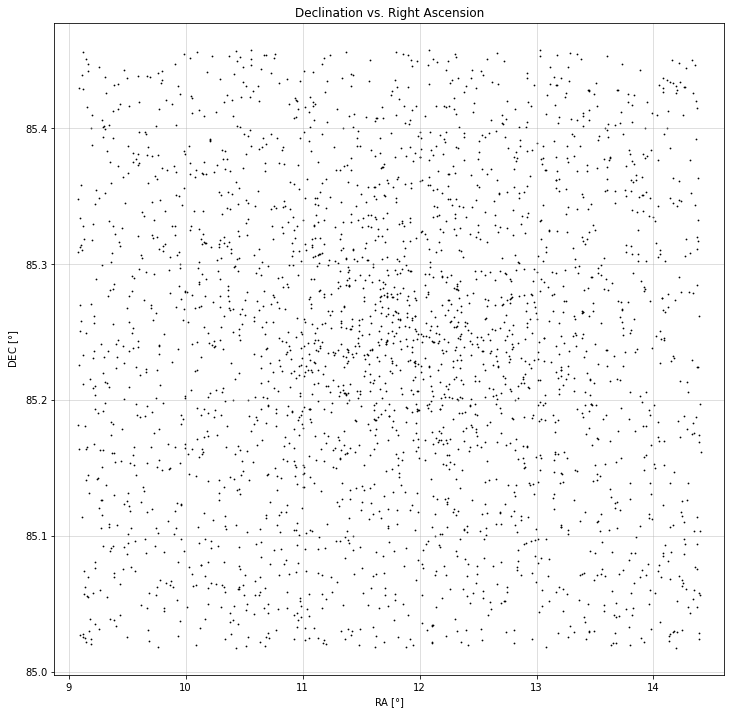

In [20]:
#plotting dec vs ra
plt.figure(figsize = (12,12))
plt.scatter(results_df2['ra'], results_df2['dec'], s = 0.6, color = 'k')
plt.xlabel(r'RA $[\degree]$')
plt.ylabel(r'DEC $[\degree]$')
plt.title('Declination vs. Right Ascension')
plt.xlim(min(results_df2['ra'])-0.2, max(results_df2['ra'])+0.2)
plt.ylim(min(results_df2['dec'])-0.02, max(results_df2['dec'])+0.02)
plt.grid(alpha = 0.5)

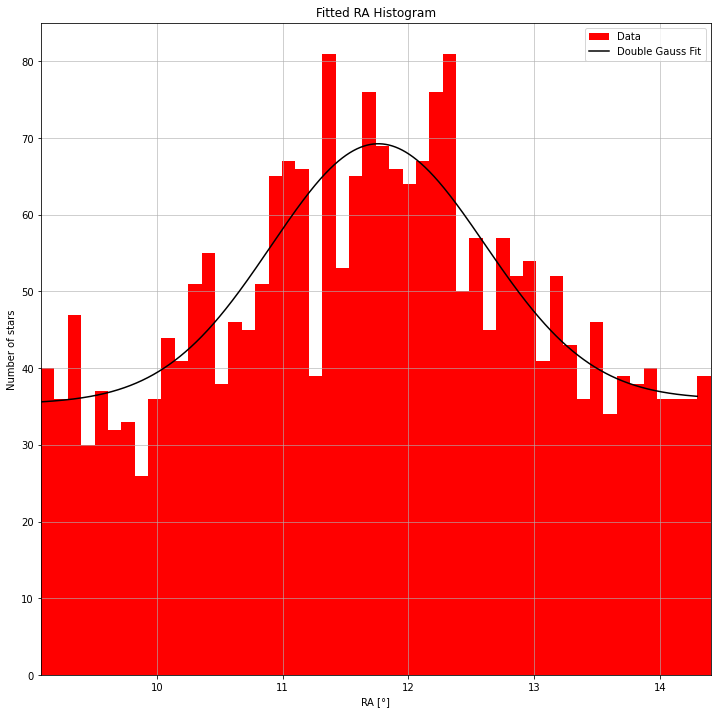

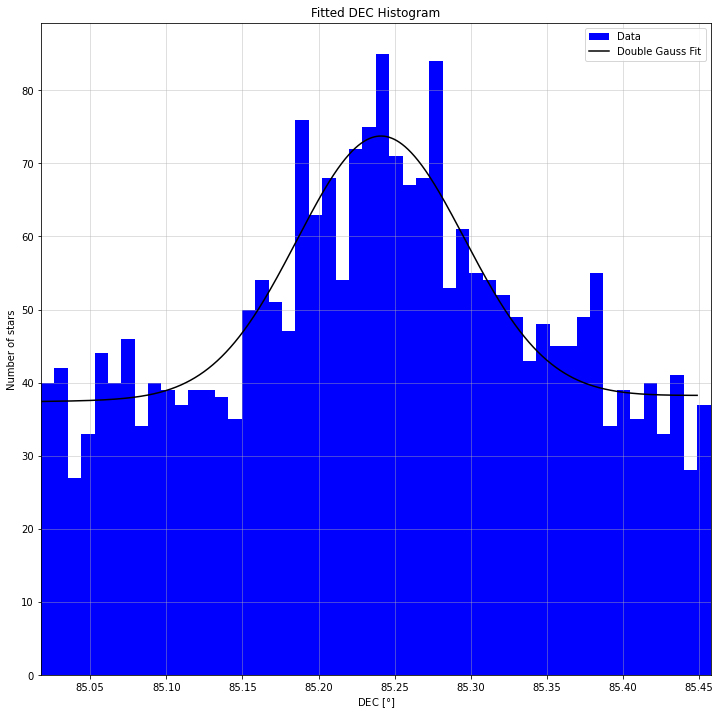

In [21]:
#removing bad data
index = results_df2[((1 / (results_df2['parallax'] * 0.001)) > 12500)].index
results_df2.drop(index, inplace = True)
index = results_df2[(results_df2['pmra'] > 10)].index
results_df2.drop(index, inplace = True)
index = results_df2[(results_df2['pmra'] < -10)].index
results_df2.drop(index, inplace = True)
index = results_df2[(results_df2['pmdec'] > 10)].index
results_df2.drop(index, inplace = True)
index = results_df2[(results_df2['pmdec'] < -10)].index
results_df2.drop(index, inplace = True)

#defining our data, bins
ras2 = results_df2['ra']
decs2 = results_df2['dec']
numbins_radec2 = 50

#making histograms, fixing index error
rahist2, rabins2 = np.histogram(ras2, bins = numbins_radec2)
dechist2, decbins2 = np.histogram(decs2, bins = numbins_radec2)
rahist2, rabins2 = rahist2[:numbins_radec2], rabins2[:numbins_radec2]
dechist2, decbins2 = dechist2[:numbins_radec2], decbins2[:numbins_radec2]

#fitting
poptra2, pcovra2 = curve_fit(dublgauss, rabins2, rahist2, maxfev = 100000, p0 = (60, 12, 2, 20, 12, 0.1))
poptdec2, pcovdec2 = curve_fit(dublgauss, decbins2, dechist2, maxfev = 100000, p0 = (60, 85.3, 2, 80, 85.3, 0.1))

#more continuous data
ramodel_x_data2 = np.linspace(min(rabins2), max(rabins2), 10000)
ramodel_y_data2 = dublgauss(ramodel_x_data2, * poptra2)
decmodel_x_data2 = np.linspace(min(decbins2), max(decbins2), 10000)
decmodel_y_data2 = dublgauss(decmodel_x_data2, * poptdec2)

#plotting
plt.figure(0, figsize = (12,12))
plt.hist(ras2, bins = numbins_radec2, color = 'r', label = 'Data')
plt.plot(ramodel_x_data2, ramodel_y_data2, label = 'Double Gauss Fit', color = 'k')
plt.title('Fitted RA Histogram')
plt.xlabel(r'RA $[\degree]$')
plt.ylabel('Number of stars')
plt.xlim(min(ras2), max(ras2))
plt.legend()
plt.grid(alpha = 0.75)

plt.figure(1, figsize = (12,12))
plt.hist(decs2, bins = numbins_radec2, color = 'b', label = 'Data')
plt.plot(decmodel_x_data2, decmodel_y_data2, label = 'Double Gauss Fit', color = 'k')
plt.title('Fitted DEC Histogram')
plt.xlabel(r'DEC $[\degree]$')
plt.ylabel('Number of stars')
plt.xlim(min(decs2), max(decs2))
plt.legend()
plt.grid(alpha = 0.5)

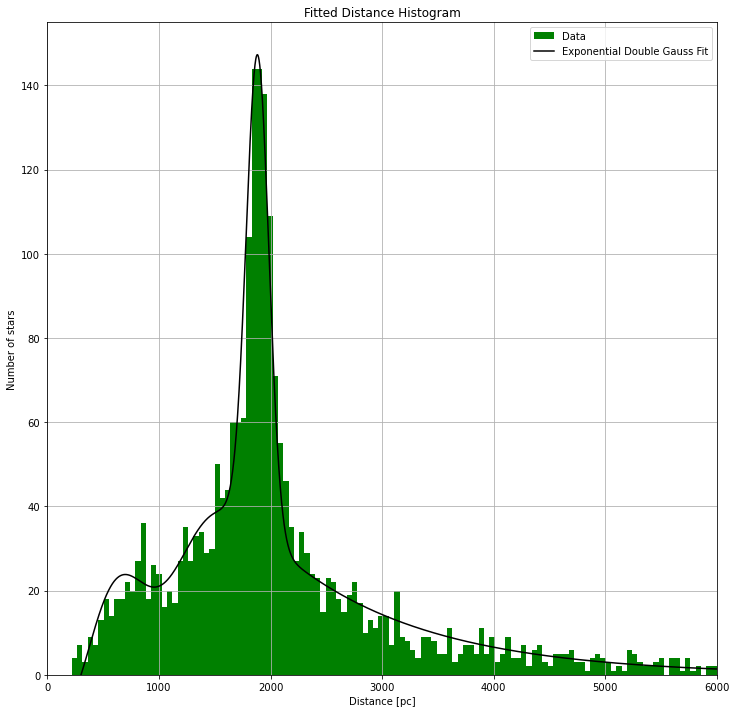

In [22]:
#defining data, bins
parallax_in_arcsec2 = results_df2['parallax'] * 0.001
distances2 = 1/parallax_in_arcsec2
numbins_dist2 = 250

#making histograms, fixing index error
disthist2, distbins2 = np.histogram(distances2, bins = numbins_dist2)
disthist2, distbins2 = disthist2[:numbins_dist2], distbins2[:numbins_dist2]

#fitting
poptdist2, pcovdist2 = curve_fit(my_custom_function, distbins2, disthist2, maxfev = 100000,
                              p0 = (31, 950, 120000, 55.7, 2000, 200000, 100000, 20, -0.00025))

#more continuous data
distmodel_x_data2 = np.linspace(min(distbins2), max(distbins2), 10000)
distmodel_y_data2 = my_custom_function(distmodel_x_data2, *poptdist2)

#plotting
plt.figure(figsize = (12,12))
plt.hist(distances2, bins = numbins_dist2, color = 'g', label = 'Data')
plt.plot(distmodel_x_data2, distmodel_y_data2, label = 'Exponential Double Gauss Fit', color = 'k')
plt.xlim(0, 6000)
plt.ylim(0)
plt.title('Fitted Distance Histogram')
plt.xlabel('Distance [pc]')
plt.ylabel('Number of stars')
plt.legend()
plt.grid()

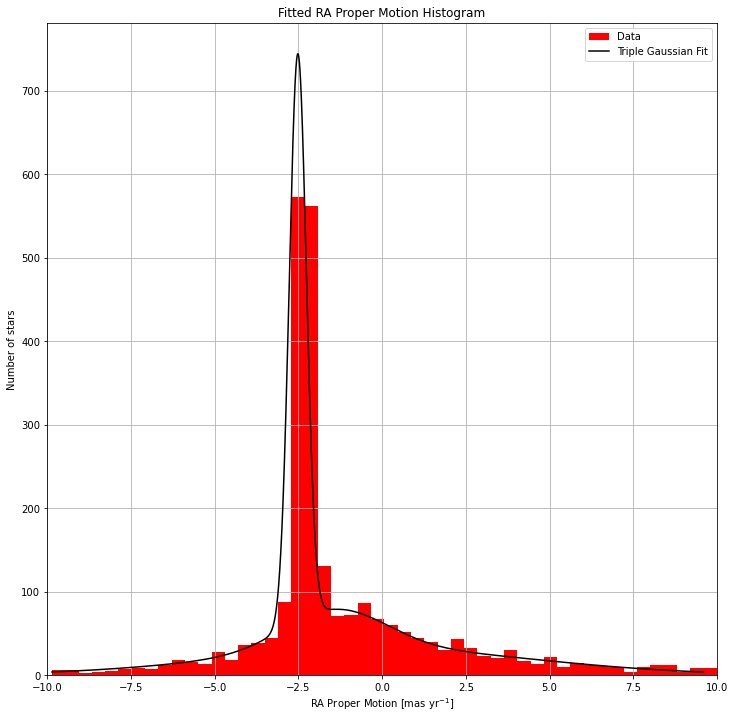

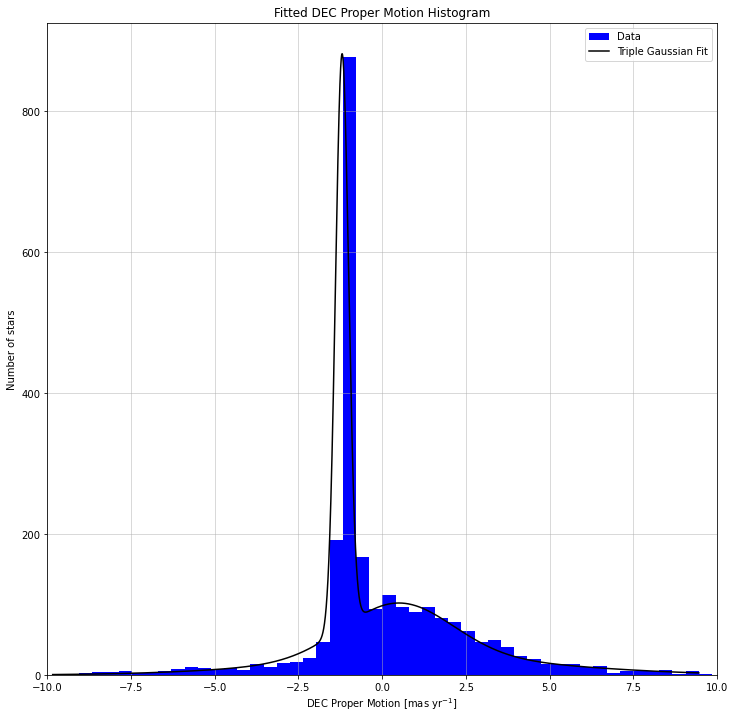

In [23]:
#defining data, bins
pm_ra2 = results_df2['pmra']
pm_dec2 = results_df2['pmdec']
numbins_pm2 = 50

#making histograms, fixing index error
pm_rahist2, pm_rabins2 = np.histogram(pm_ra2, bins = numbins_pm2)
pm_rahist2, pm_rabins2 = pm_rahist2[:numbins_pm2], pm_rabins2[:numbins_pm2]
pm_dechist2, pm_decbins2 = np.histogram(pm_dec2, bins = numbins_pm2)
pm_dechist2, pm_decbins2 = pm_dechist2[:numbins_pm2], pm_decbins2[:numbins_pm2]

#fitting
poptpm_ra2, pcovpm_ra2 = curve_fit(triplgauss, pm_rabins2, pm_rahist2, maxfev = 100000,
                                p0 = (60, -0.5, 1, 500, -2.1, 0.25, 20, -0.5, 10))
poptpm_dec2, pcovpm_dec2 = curve_fit(triplgauss, pm_decbins2, pm_dechist2, maxfev = 100000,
                                  p0 = (200, 1, 3, 300, -1, 0.1, 10, -1, 10))

#more continuous data
pm_ramodel_x_data2 = np.linspace(min(pm_rabins2), max(pm_rabins2), 10000)
pm_ramodel_y_data2 = triplgauss(pm_ramodel_x_data2, *poptpm_ra2)
pm_decmodel_x_data2 = np.linspace(min(pm_decbins2), max(pm_decbins2), 10000)
pm_decmodel_y_data2 = triplgauss(pm_decmodel_x_data2, *poptpm_dec2)

#plotting
plt.figure(0, figsize = (12,12))
plt.hist(pm_ra2, bins = numbins_pm2, color = 'r', label = 'Data')
plt.plot(pm_ramodel_x_data2, pm_ramodel_y_data2, label = 'Triple Gaussian Fit', color = 'k')
plt.xlim(-10, 10)
plt.title('Fitted RA Proper Motion Histogram')
plt.xlabel('RA Proper Motion [mas yr$^{-1}$]')
plt.ylabel('Number of stars')
plt.legend()
plt.grid()

plt.figure(1, figsize = (12,12))
plt.hist(pm_dec2, bins = numbins_pm2, color = 'b', label = 'Data')
plt.plot(pm_decmodel_x_data2, pm_decmodel_y_data2, label = 'Triple Gaussian Fit', color = 'k')
plt.xlim(-10, 10)
plt.title('Fitted DEC Proper Motion Histogram')
plt.xlabel('DEC Proper Motion [mas yr$^{-1}$]')
plt.ylabel('Number of stars')
plt.legend()
plt.grid(alpha = 0.6)

In [24]:
#re-defining and re-printing the things we printed early to check our work
center_ra2 = poptra2[4]
center_dec2 = poptdec2[4]
print('Best center position is (RA, DEC) = ({ra:.4f}, {dec:.4f}) deg'.format(ra = center_ra2, dec = center_dec2))

dist_to_cluster2 = poptdist2[4]
print('Center distance is {:.2f} pc'.format(dist_to_cluster2))

best_pm_ra2 = poptpm_ra2[4]
best_pm_dec2 = poptpm_dec2[4]
print('Best proper motion in RA, DEC is = ({pm_ra:.2f}, {pm_dec:.2f}) mas/yr'.format(pm_ra = best_pm_ra2, pm_dec = best_pm_dec2))

best_vd_ra2 = poptpm_ra2[5]
best_vd_dec2 = poptpm_dec2[5]
print('Best velocity dispersion in RA, DEC is = ({vd_ra:.2f}, {vd_dec:.2f}) mas/yr'.format(vd_ra = best_vd_ra2, vd_dec = best_vd_dec2))

Best center position is (RA, DEC) = (11.7579, 85.2409) deg
Center distance is 1884.03 pc
Best proper motion in RA, DEC is = (-2.52, -1.20) mas/yr
Best velocity dispersion in RA, DEC is = (0.26, 0.20) mas/yr


We were able to get a much higher "P" value this time of 0.93! We have Nc_Nf_ratio_average of 0.5135 and 
[len(goodra) / (len(badra))] of 0.5129


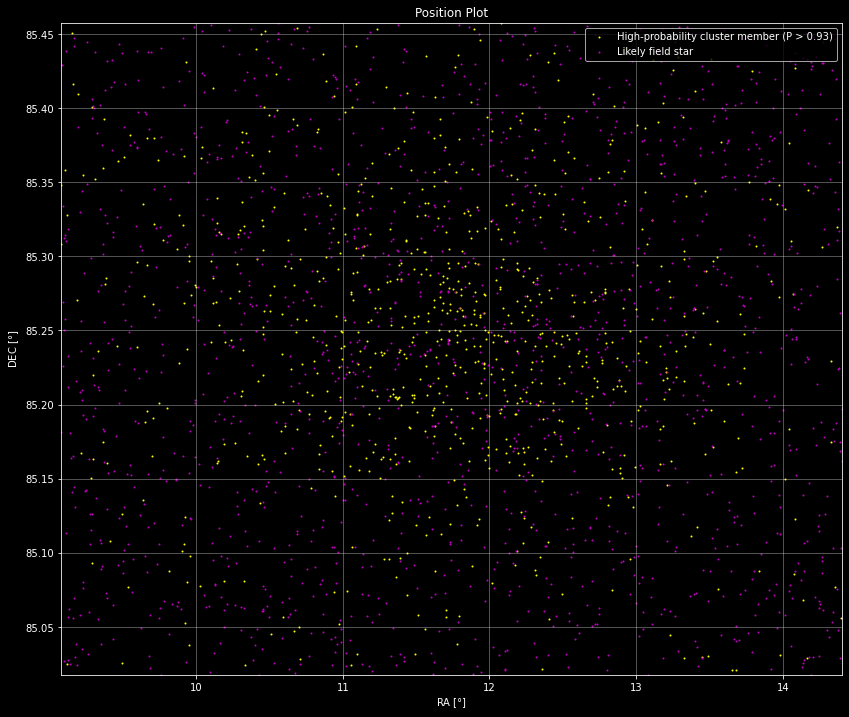

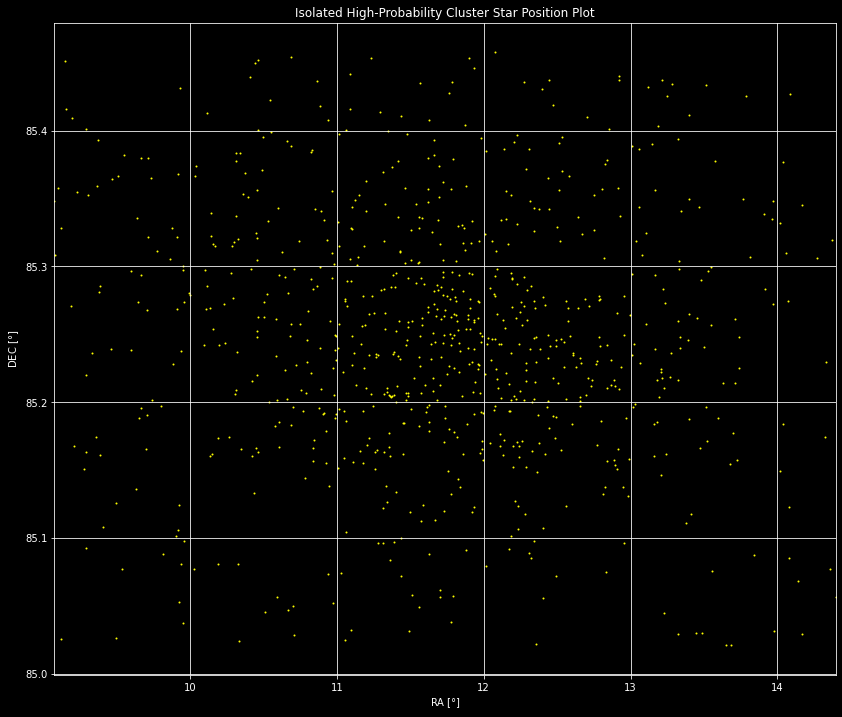

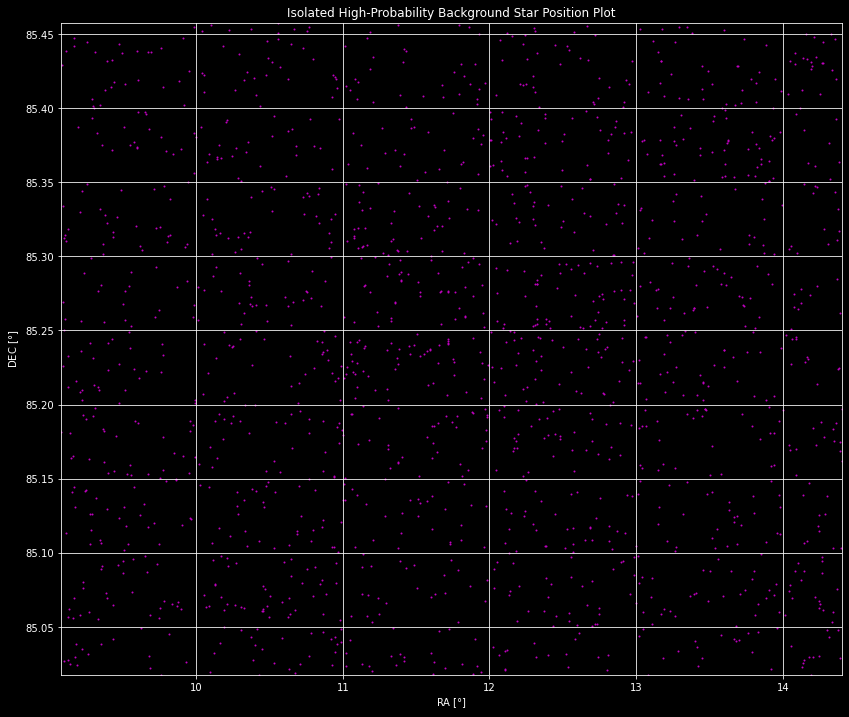

In [25]:
#separating cluster from field fits
poptra_cluster2 = poptra2.copy()
poptra_cluster2[0] = 0
poptra_field2 = poptra2.copy()
poptra_field2[3] = 0
poptdec_cluster2 = poptdec2.copy()
poptdec_cluster2[0] = 0
poptdec_field2 = poptdec2.copy()
poptdec_field2[3] = 0
poptdist_cluster2 = poptdist2.copy()
poptdist_cluster2[0] = 0
poptdist_cluster2[7] = 0
poptdist_field2 = poptdist2.copy()
poptdist_field2[3] = 0
poptpm_ra_cluster2 = poptpm_ra2.copy()
poptpm_ra_cluster2[0] = 0
poptpm_ra_cluster2[6] = 0
poptpm_ra_field2 = poptpm_ra2.copy()
poptpm_ra_field2[3] = 0
poptpm_dec_cluster2 = poptpm_dec2.copy()
poptpm_dec_cluster2[0] = 0
poptpm_dec_cluster2[6] = 0
poptpm_dec_field2 = poptpm_dec2.copy()
poptpm_dec_field2[3] = 0

#creating cluster and field fit data
ra_y_c2 = dublgauss(ramodel_x_data2, * poptra_cluster2)
dec_y_c2 = dublgauss(decmodel_x_data2, * poptdec_cluster2)
ra_y_f2 = dublgauss(ramodel_x_data2, * poptra_field2)
dec_y_f2 = dublgauss(decmodel_x_data2, * poptdec_field2)
dist_y_c2 = my_custom_function(distmodel_x_data2, *poptdist_cluster2)
dist_y_f2 = my_custom_function(distmodel_x_data2, *poptdist_field2)
pmra_y_c2 = triplgauss(pm_ramodel_x_data2, *poptpm_ra_cluster2)
pmra_y_f2 = triplgauss(pm_ramodel_x_data2, *poptpm_ra_field2)
pmdec_y_c2 = triplgauss(pm_decmodel_x_data2, *poptpm_dec_cluster2)
pmdec_y_f2 = triplgauss(pm_decmodel_x_data2, *poptpm_dec_field2)

#defining some membership probability function parameters
sigmax2, sigmay2 = best_vd_ra2, best_vd_dec2
muxc2, muyc2 = best_pm_ra2, best_pm_dec2
muxf2, muyf2 = poptpm_ra2[1], poptpm_dec2[1]
bigsigmax2, bigsigmay2 = poptpm_ra2[2], poptpm_dec2[2]

#integrating for Nc and Nf
Nc_ra2 = simpson(ra_y_c2, dx = dx)
Nc_dec2 = simpson(dec_y_c2, dx = dx)
Nf_ra2 = simpson(ra_y_f2, dx = dx)
Nf_dec2 = simpson(dec_y_f2, dx = dx)
Nc_d2 = simpson(dist_y_c2, dx = dx)
Nf_d2 = simpson(dist_y_f2, dx = dx)
Nc_ra_pm2 = simpson(pmra_y_c2, dx = dx)
Nc_dec_pm2 = simpson(pmdec_y_c2, dx = dx)
Nf_ra_pm2 = simpson(pmra_y_f2, dx = dx)
Nf_dec_pm2 = simpson(pmdec_y_f2, dx = dx)

#getting Nc:Nf ratios for each fit
Nc_Nf_ratio_ra2 = Nc_ra2 / Nf_ra2
Nc_Nf_ratio_dec2 = Nc_dec2 / Nf_dec2
Nc_Nf_ratio_d2 = Nc_d2 / Nf_d2
Nc_Nf_ratio_pmra2 = Nc_ra_pm2 / Nf_ra_pm2
Nc_Nf_ratio_pmdec2 = Nc_dec_pm2 / Nf_dec_pm2

#getting Nc:Nf average from all fits
Nc_Nf_ratio_average2 = (Nc_Nf_ratio_ra2 + Nc_Nf_ratio_dec2 + Nc_Nf_ratio_d2 + Nc_Nf_ratio_pmra2 + Nc_Nf_ratio_pmdec2) / 5

#known number of total stars
total_stars2 = len(results_df2)

#final Nc and Nf from total stars
Nc2 = total_stars2 * Nc_Nf_ratio_average2
Nf2 = total_stars2 - Nc2

#re-defining same functions for use with our new variable names
def phiC2(mux, muy):
    return (Nc2 / (2 * np.pi * sigmax2 * sigmay2)) * np.exp(-((((mux - muxc2)**2) / (2 * sigmax2**2)) + (((muy - muyc2)**2) / (2 * sigmay2**2))))
def phif2(mux, muy):
    return (Nf2 / (2 * np.pi * bigsigmax2 * bigsigmay2)) * np.exp(-((((mux - muxf2)**2) / (2 * bigsigmax2**2)) + (((muy - muyf2)**2) / (2 * bigsigmay2**2))))

#calculating membership probability for each star
probs2 = np.array([])
for i in range(len(results_df2)):
    phi_c = phiC2(results_df2['pmra'].values[i], results_df2['pmdec'].values[i])
    phi_f = phif2(results_df2['pmra'].values[i], results_df2['pmdec'].values[i])
    prob = phi_c / (phi_f + phi_c)
    probs2 = np.append(probs2, prob)

#getting data from df to np arrays
(objid2, ra2, ra_err2, dec2, dec_err2, plx2, plx_err2, pmra2, pmra_err2, pmdec2, pmdec_err2, 
 gmag, rpmag) = (np.transpose(results_df2.to_numpy()))

#defining empty arrays to fill
(probs2_c, goodra2, gooddec2, goodpmra2, goodpmdec2, goodplx2, goodra_err2, gooddec_err2, goodgmag, goodrpmag,
 badra2, baddec2, badpmra2, badpmdec2, badplx2, badra_err2, baddec_err2, badgmag, 
 badrpmag) = (np.array([]), np.array([]),np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), 
              np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), 
              np.array([]), np.array([]), np.array([]), np.array([]))

#defining cluster and field data
for i in range(len(probs2)):
    if probs2[i] > 0.93:
        goodra2 = np.append(goodra2, ra2[i])
        gooddec2 = np.append(gooddec2, dec2[i])
        goodpmra2 = np.append(goodpmra2, pmra2[i])
        goodpmdec2 = np.append(goodpmdec2, pmdec2[i])
        goodplx2 = np.append(goodplx2, plx2[i])
        goodra_err2 = np.append(goodra_err2, ra_err2[i])
        gooddec_err2 = np.append(gooddec_err2, dec_err2[i])
        goodgmag = np.append(goodgmag, gmag[i])
        goodrpmag = np.append(goodrpmag, rpmag[i])
        probs2_c = np.append(probs2_c, probs2[i])
    else:
        badra2 = np.append(badra2, ra2[i])
        baddec2 = np.append(baddec2, dec2[i])
        badpmra2 = np.append(badpmra2, pmra2[i])
        badpmdec2 = np.append(badpmdec2, pmdec2[i])
        badplx2 = np.append(badplx2, plx2[i])
        badra_err2 = np.append(badra_err2, ra_err2[i])
        baddec_err2 = np.append(baddec_err2, dec_err2[i])
        badgmag = np.append(badgmag, gmag[i])
        badrpmag = np.append(badrpmag, rpmag[i])

#plotting dec vs ra with likely cluster members highlighted
plt.style.use('dark_background')
plt.figure(0, figsize = (14,12))
plt.scatter(goodra2, gooddec2, s = 1, label = 'High-probability cluster member (P > 0.93)', color = 'yellow')
plt.scatter(badra2, baddec2, s = 1, label = 'Likely field star', color = 'm')
plt.title('Position Plot')
plt.xlabel(r'RA $[\degree]$')
plt.ylabel(r'DEC $[\degree]$')
plt.xlim(min(ra2), max(ra2))
plt.ylim(min(dec2), max(dec2))
plt.legend()
plt.grid(alpha = 0.4)

#plotting just the likely cluster members
plt.figure(1, figsize = (14,12))
plt.scatter(goodra2, gooddec2, s = 1, color = 'yellow')
plt.title('Isolated High-Probability Cluster Star Position Plot')
plt.xlabel(r'RA $[\degree]$')
plt.ylabel(r'DEC $[\degree]$')
plt.xlim(min(goodra2), max(goodra2))
plt.grid()

#plotting just the likely field stars
plt.figure(2, figsize = (14,12))
plt.scatter(badra2, baddec2, s = 1, color = 'm')
plt.title('Isolated High-Probability Background Star Position Plot')
plt.xlabel(r'RA $[\degree]$')
plt.ylabel(r'DEC $[\degree]$')
plt.xlim(min(ra2), max(ra2))
plt.ylim(min(dec2), max(dec2))
plt.grid()

print('''We were able to get a much higher "P" value this time of 0.93! We have Nc_Nf_ratio_average of {ratio:.4f} and 
[len(goodra) / (len(badra))] of {leng:.4f}'''.format(ratio = Nc_Nf_ratio_average2, leng = len(goodra2) / len(badra2)))

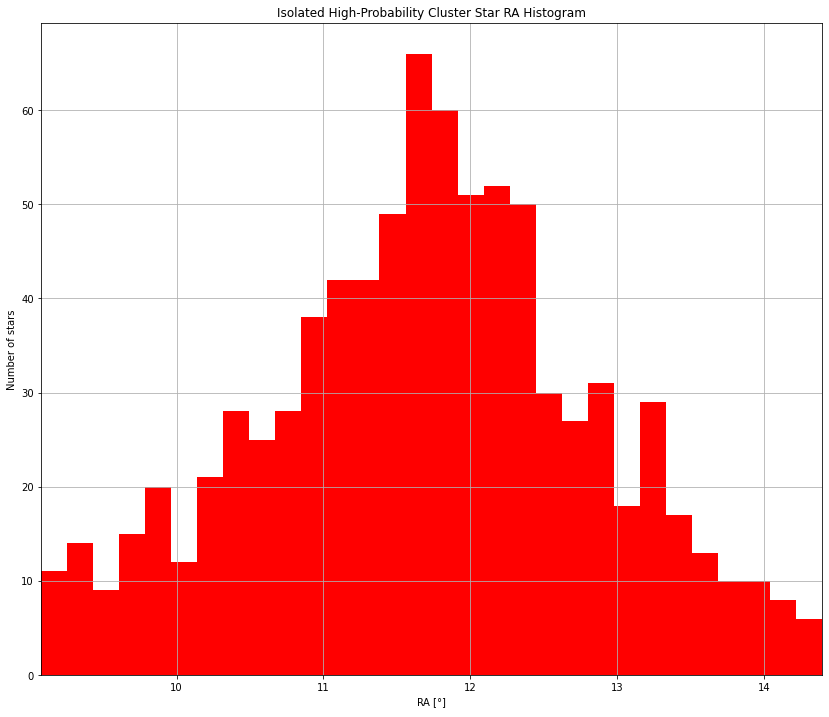

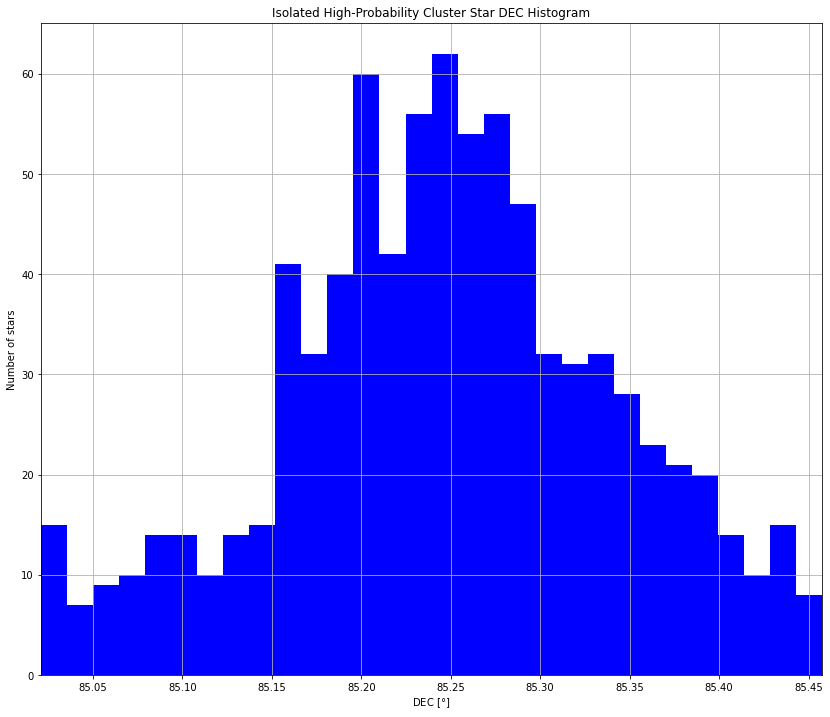

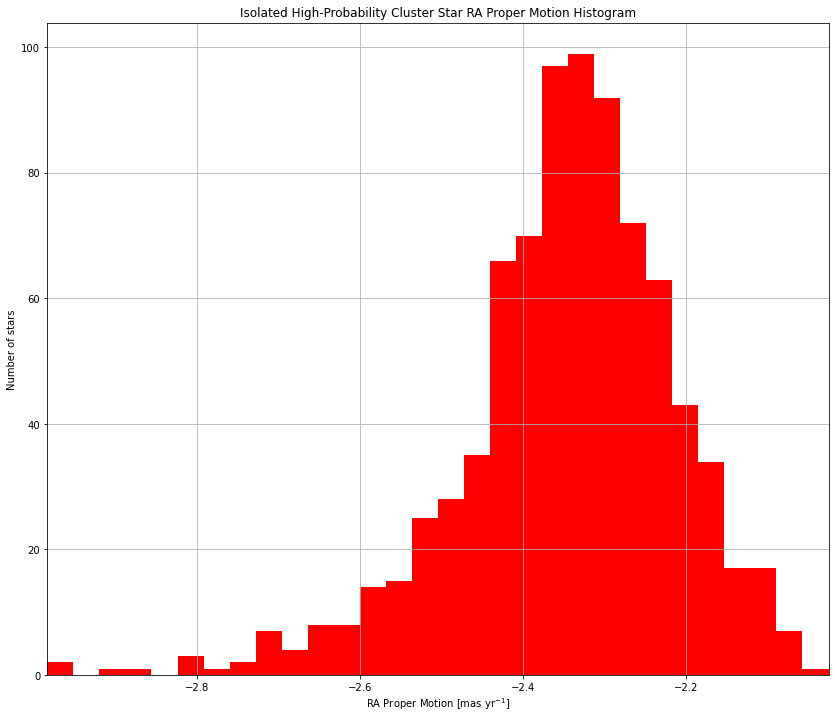

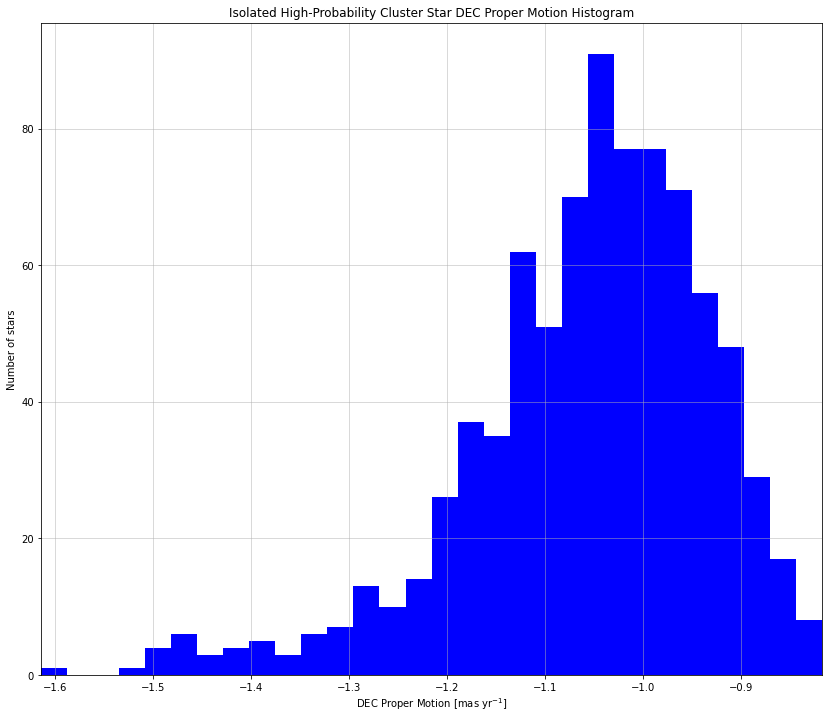

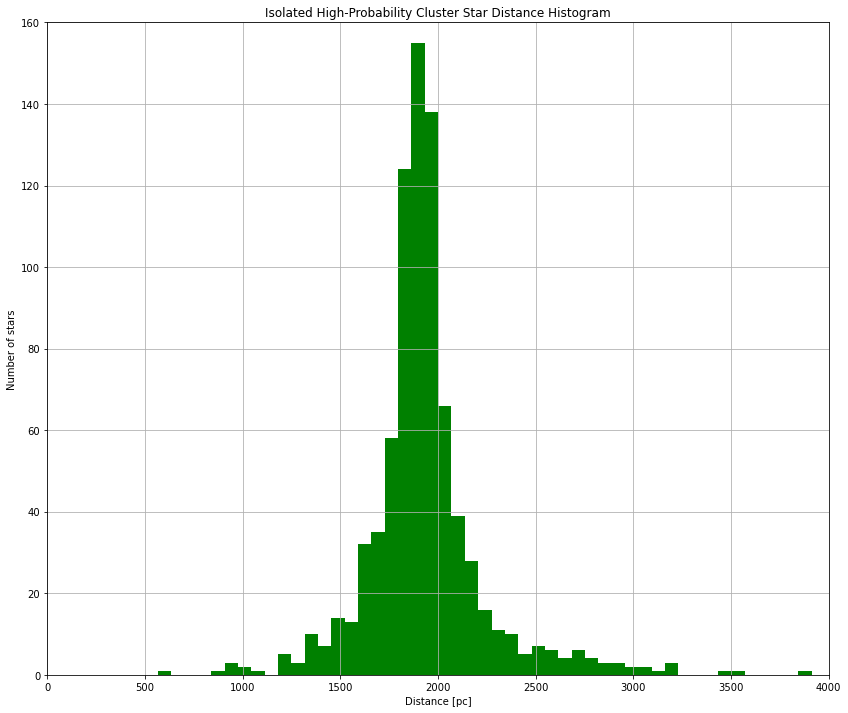

In [26]:
#Again, just curiosity, feel free to ignore
plt.style.use('default')
%matplotlib inline

#plotting isolated cluster histograms again
plt.figure(0, figsize = (14,12))
plt.title('Isolated High-Probability Cluster Star RA Histogram')
plt.hist(goodra2, bins = 30, color = 'r')
plt.xlim(min(goodra2), max(goodra2))
plt.xlabel(r'RA $[\degree]$')
plt.ylabel('Number of stars')
plt.grid()

plt.figure(1, figsize = (14,12))
plt.title('Isolated High-Probability Cluster Star DEC Histogram')
plt.hist(gooddec2, bins = 30, color = 'b')
plt.xlim(min(gooddec2), max(gooddec2))
plt.xlabel(r'DEC $[\degree]$')
plt.ylabel('Number of stars')
plt.grid()

plt.figure(2, figsize = (14,12))
plt.hist(goodpmra2, bins = 30, color = 'r')
plt.title('Isolated High-Probability Cluster Star RA Proper Motion Histogram')
plt.xlim(min(goodpmra2), max(goodpmra2))
plt.xlabel('RA Proper Motion [mas yr$^{-1}$]')
plt.ylabel('Number of stars')
plt.grid()

plt.figure(3, figsize = (14,12))
plt.hist(goodpmdec2, bins = 30, color = 'b')
plt.title('Isolated High-Probability Cluster Star DEC Proper Motion Histogram')
plt.xlim(min(goodpmdec2), max(goodpmdec2))
plt.xlabel('DEC Proper Motion [mas yr$^{-1}$]')
plt.ylabel('Number of stars')
plt.grid(alpha = 0.6)

good_d2 = 1 / (goodplx2 * 0.001)
plt.figure(4, figsize = (14,12))
plt.title('Isolated High-Probability Cluster Star Distance Histogram')
plt.hist(good_d2, bins = 150, color = 'g')
plt.xlim(0, 4000)
plt.ylim(0, 160)
plt.xlabel('Distance [pc]')
plt.ylabel('Number of stars')
plt.grid()

In [27]:
#GAIA CMD--------------------------------------------------------------------------------------------------------------------
#calculating distance with parallax
dist2 = 1 / (results_df2['parallax'] * 0.001)

#using distance and apparent mag to calculate absolute mag
g_abs_mag = results_df2['phot_g_mean_mag'] - (5 * (np.log10(dist2) - 1))
rp_abs_mag = results_df2['phot_rp_mean_mag'] - (5 * (np.log10(dist2) - 1))

#putting our probability array from earlier directly into the dataframe
results_df2['prob'] = probs2

#tick formatting things
def myfmtx(x,pos):
    """
    Returns a format out to two decimal places for x < 0, a format with no decimal places for x = 0, and a format
    of two decimal places for x > 0, that also includes a plus sign in front of the number for x > 0.
    """
    if x < 0:
        return u"${:.1f}$".format(x)
    elif x ==0:
        return u"${:.0f}$".format(x)
    else:
        return u"$+{:.1f}$".format(x)
def myfmty(x,pos):
    """
    We only have positive values on our y-axis, so this function always returns a format that includes a 
    plus sign in front of our tick values.
    """
    if x < 0:
        return u"${:.0f}$".format(x)
    elif x ==0:
        return u"${:.0f}$".format(x)
    else:
        return u"$+{:.0f}$".format(x)
xfmt = ticker.FuncFormatter(myfmtx)
yfmt = ticker.FuncFormatter(myfmty)

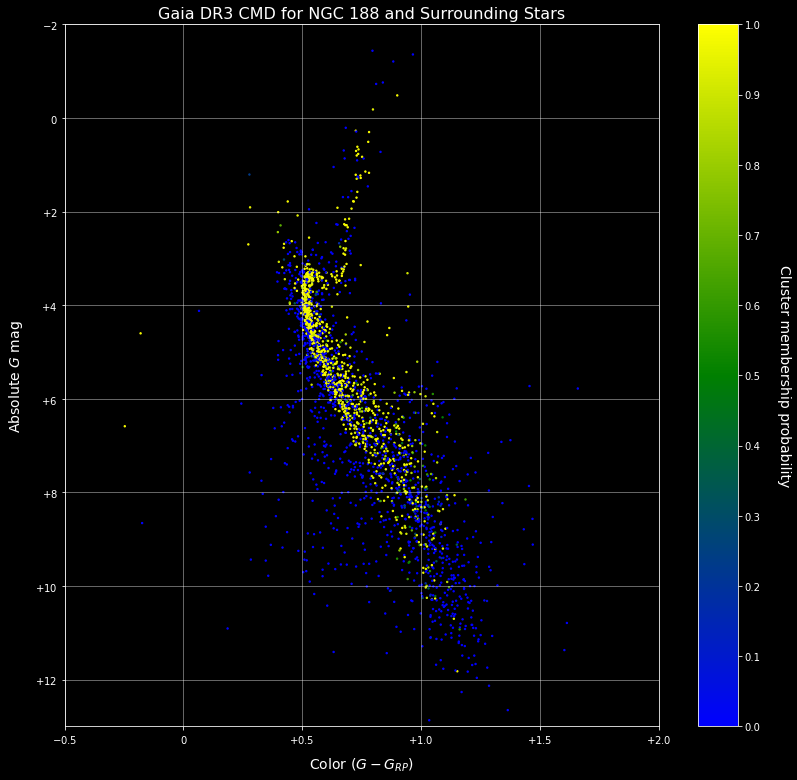

In [39]:
plt.style.use('dark_background')

#defining a colormap and normalization for our CMD
my_cmap1 = LinearSegmentedColormap.from_list('hrdiagram', ['blue', 'green', 'yellow'])
norm1 = plt.Normalize(0, 1)

#setting up plot
fig = plt.figure(figsize=(11,13))
ax = fig.add_axes([0, 0, 0.75, 0.75])
ax.grid(alpha = 0.5)

#plotting data color-coded by probability
s = ax.scatter(g_abs_mag - rp_abs_mag, g_abs_mag, c = results_df2['prob'], s = 2, cmap = my_cmap1, norm = norm1)

#making plot look nice
plt.rcParams['axes.titlesize'] = 16
ax.set(title = 'Gaia DR3 CMD for NGC 188 and Surrounding Stars')
ax.set_ylim(13, -2)
ax.set_xlim(-0.5, 2)
ax.set_xlabel(r'Color $(G - G_{RP})$', fontsize = 14, labelpad = 10)
ax.set_ylabel(r'Absolute $G$ mag', fontsize = 14, labelpad = 10)
ax.xaxis.set_major_formatter(xfmt)
ax.yaxis.set_major_formatter(yfmt)

#setting up and plotting our colorbar
colorbar_ax = fig.add_axes([0.8, 0, 0.05, 0.75])
fig.colorbar(s, cax = colorbar_ax)
colorbar_ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
colorbar_ax.set_ylabel('Cluster membership probability', labelpad = 30, rotation = 270, fontsize = 14);

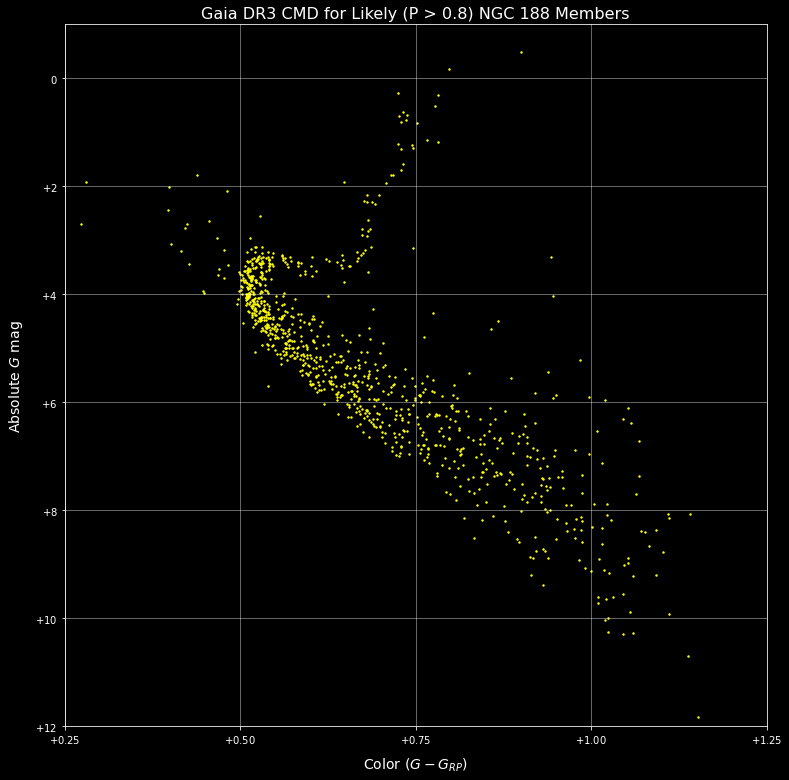

In [40]:
#more tick formatting things
def myfmtx2(x,pos):
    """
    Returns a format out to two decimal places for x < 0, a format with no decimal places for x = 0, and a format
    of two decimal places for x > 0, that also includes a plus sign in front of the number for x > 0.
    """
    if x < 0:
        return u"${:.2f}$".format(x)
    elif x ==0:
        return u"${:.0f}$".format(x)
    else:
        return u"$+{:.2f}$".format(x)
xfmt2 = ticker.FuncFormatter(myfmtx2)

#defining a new dataframe with only high probability cluster members
gaia_high_prob = results_df2[results_df2['prob'] > 0.8]

#calculating distance for high probability members
dist2_high_prob = 1 / (gaia_high_prob['parallax'] * 0.001)

#calculating absolute mag for high probability members
g_abs_mag_highp = gaia_high_prob['phot_g_mean_mag'] - (5 * (np.log10(dist2_high_prob) - 1))
rp_abs_mag_highp = gaia_high_prob['phot_rp_mean_mag'] - (5 * (np.log10(dist2_high_prob) - 1))

#defining x and y data for our CMD, making them numpy arrays to prevent an error later
x_g = np.array(g_abs_mag_highp - rp_abs_mag_highp)
y_g = np.array(g_abs_mag_highp)

#setting up plot
fig = plt.figure(figsize=(13,13))
ax = fig.add_axes([0, 0, 0.75, 0.75])
ax.grid(alpha = 0.5)

#plotting high probability data
ax.scatter(x_g, y_g, c = 'yellow', s = 2, label = 'High-probability cluster member (P > 0.8)')

#making plot look nice
plt.rcParams['axes.titlesize'] = 16
ax.set(title = 'Gaia DR3 CMD for Likely (P > 0.8) NGC 188 Members')
ax.set_ylim(12, -1)
ax.set_xlim(0.25, 1.25)
ax.set_xlabel(r'Color $(G - G_{RP})$', fontsize = 14, labelpad = 10)
ax.set_ylabel(r'Absolute $G$ mag', fontsize = 14, labelpad = 10)
ax.set_xticks([0.25, 0.50, 0.75, 1, 1.25])
ax.xaxis.set_major_formatter(xfmt2)
ax.yaxis.set_major_formatter(yfmt);

In [30]:
#the most important part of the isochrone to "fit" is around the turn off point, so
#i'm placing these bounds to only focus on the important part of the isochrone with
#the sum of least squares function below. additionally, i've gotten rid of some outliers
#by getting rid of x data less than 0
mask_y_l = y_g > 2
y_g_for_fit = y_g[mask_y_l]
x_g_for_fit = x_g[mask_y_l]
mask_y_u = y_g_for_fit < 6
y_g_for_fit = y_g_for_fit[mask_y_u]
x_g_for_fit = x_g_for_fit[mask_y_u]
mask_x_l = x_g_for_fit > 0
y_g_for_fit = y_g_for_fit[mask_x_l]
x_g_for_fit = x_g_for_fit[mask_x_l]

#defining a function to find best age and metallicity parameters for an isochrone for our data
def objective(params):
    #defining parameters, getting our isochrone, defining more variables
    A, B = params
    r = parsec.get_one_isochrone(A, B, model = 'parsec12s', phot = 'gaia', ret_table = True)
    GRP = r['G'] - r['G_RP']
    G = r['G']    
    
    #getting rid of less useful data again
    mask = G > 2
    G = G[mask]
    GRP = GRP[mask]    
    mask = G < 6
    G = G[mask]
    GRP = GRP[mask]    
    mask = GRP > 0
    G = G[mask]
    GRP = GRP[mask]

    #getting rid of duplicate indices so i can interpolate the model isochrone data
    unique_elements, indices = np.unique(GRP, return_index = True)
    duplicate_indices = np.setdiff1d(np.arange(len(GRP)), indices)
    GRP = np.delete(GRP, duplicate_indices)
    G = np.delete(G, duplicate_indices)

    #interpolating isochrone data so the length of the arrays are the same, so we can
    #subtract them from our actual data and get squared error
    spline = interp1d(GRP, G, kind = 'nearest', bounds_error = False, fill_value = "extrapolate")
    GRP_new = np.linspace(min(GRP), max(GRP), num = len(x_g_for_fit))
    G_new = spline(GRP_new)
     
    #getting squared error as in difference from known data
    x_err = (x_g_for_fit - GRP_new) ** 2
    y_err = (y_g_for_fit - G_new) ** 2
    return sum(x_err) + sum(y_err)

#defining initial guesses and bounds
initial_guess = [6.9e+09, 2.7e-02]
bounds = [(6e9, 7.5e9), (0.02, 0.035)]

#minimizing sum of squared error, printing our results
res = minimize(objective, initial_guess, method='nelder-mead', bounds=bounds, options={'xtol':1e-1, 'disp': True, 'maxiter': 25})
print(res.x)

#defining our optimal isochrone with our optimal parameters
r_g = parsec.get_one_isochrone(res.x[0], res.x[1], model = 'parsec12s', phot = 'gaia', ret_table = True)

Interrogating http://stev.oapd.inaf.it...
Interrogating http://stev.oapd.inaf.it...
Interrogating http://stev.oapd.inaf.it...
Interrogating http://stev.oapd.inaf.it...
Interrogating http://stev.oapd.inaf.it...
Interrogating http://stev.oapd.inaf.it...
Interrogating http://stev.oapd.inaf.it...
Interrogating http://stev.oapd.inaf.it...
Interrogating http://stev.oapd.inaf.it...
Interrogating http://stev.oapd.inaf.it...
Interrogating http://stev.oapd.inaf.it...
Interrogating http://stev.oapd.inaf.it...
Interrogating http://stev.oapd.inaf.it...
Interrogating http://stev.oapd.inaf.it...
Interrogating http://stev.oapd.inaf.it...
Interrogating http://stev.oapd.inaf.it...
Interrogating http://stev.oapd.inaf.it...
Interrogating http://stev.oapd.inaf.it...
Interrogating http://stev.oapd.inaf.it...
Interrogating http://stev.oapd.inaf.it...
Interrogating http://stev.oapd.inaf.it...
Interrogating http://stev.oapd.inaf.it...
Interrogating http://stev.oapd.inaf.it...
Interrogating http://stev.oapd.ina

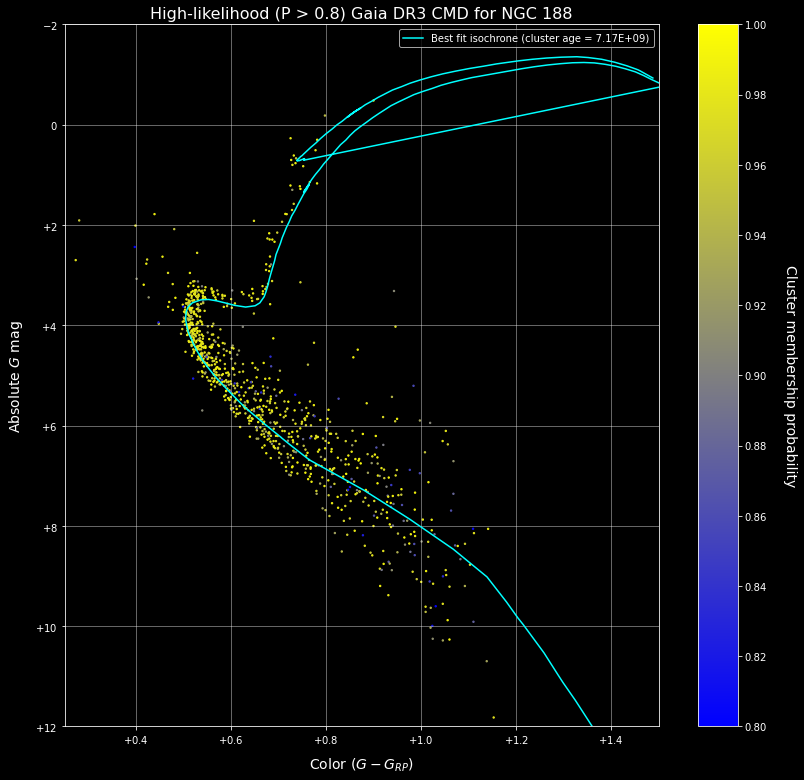

In [41]:
#defining fit data
x_g_fit = r_g['G'] - r_g['G_RP']
y_g_fit = r_g['G']

#defining a new cmap and normalization for a smaller probability range
my_cmap80 = LinearSegmentedColormap.from_list('hrdiagram', ['blue', 'yellow'])
norm80 = plt.Normalize(0.8, 1)

#setting up our plots
fig = plt.figure(figsize=(11,13))
ax = fig.add_axes([0, 0, 0.75, 0.75])
ax.grid(alpha = 0.5)

#plotting our data, color coded by membership probability
s = ax.scatter(x_g, y_g, c = gaia_high_prob['prob'], s = 2, cmap = my_cmap80, norm = norm80)

#making plot look nice
plt.rcParams['axes.titlesize'] = 16
ax.set(title = 'High-likelihood (P > 0.8) Gaia DR3 CMD for NGC 188')
ax.set_ylim(12, -2)
ax.set_xlim(0.25, 1.5)
ax.set_xlabel(r'Color $(G - G_{RP})$', fontsize = 14, labelpad = 10)
ax.set_ylabel(r'Absolute $G$ mag', fontsize = 14, labelpad = 10)
ax.xaxis.set_major_formatter(xfmt)
ax.yaxis.set_major_formatter(yfmt)

#plotting our colorbar
colorbar_ax = fig.add_axes([0.8, 0, 0.05, 0.75])
fig.colorbar(s, cax = colorbar_ax)
colorbar_ax.set_yticks([0.80, 0.82, 0.84, 0.86, 0.88, 0.90, 0.92, 0.94, 0.96, 0.98, 1.0])
colorbar_ax.set_ylabel('Cluster membership probability', labelpad = 30, rotation = 270, fontsize = 14)

#plotting our fit
ax.plot(x_g_fit, y_g_fit, color = 'cyan', label = 'Best fit isochrone (cluster age = {age:.2E})'.format(age = res.x[0]))
ax.legend();

In [32]:
#PANSTARRS CMD--------------------------------------------------------------------------------------------------------------------
#defining columns
column_list = ['gaia.source_id', 'gaia.ra', 'gaia.ra_error', 'gaia.dec', 'gaia.dec_error', 'gaia.parallax', 'gaia.parallax_error', 
               'gaia.phot_g_mean_mag', 'gaia.phot_rp_mean_mag', 'best.best_neighbour_multiplicity', 'best.number_of_mates', 
               'ps.g_mean_psf_mag', 'ps.i_mean_psf_mag', 'best.number_of_neighbours']

#new join query
query3 = """SELECT 
{columns}
FROM gaiadr2.gaia_source as gaia
JOIN gaiadr2.panstarrs1_best_neighbour as best
  ON gaia.source_id = best.source_id
JOIN gaiadr2.panstarrs1_original_valid as ps
  ON best.original_ext_source_id = ps.obj_id
WHERE gaia.parallax > 0 AND gaia.ra_error < 1 AND gaia.dec_error < 1 AND gaia.parallax_error < 1 AND
1=CONTAINS(
  POINT(gaia.ra, gaia.dec),
  BOX({cluster_ra}, {cluster_dec}, {width}, {height}))
""".format(cluster_ra = center_ra, cluster_dec = center_dec, width = width_for_query, height = height_for_query,
          columns = ', '.join(column_list))

job3 = Gaia.launch_job_async(query = query3)
results3 = job3.get_results()
results_df3 = results3.to_pandas()

INFO: Query finished. [astroquery.utils.tap.core]


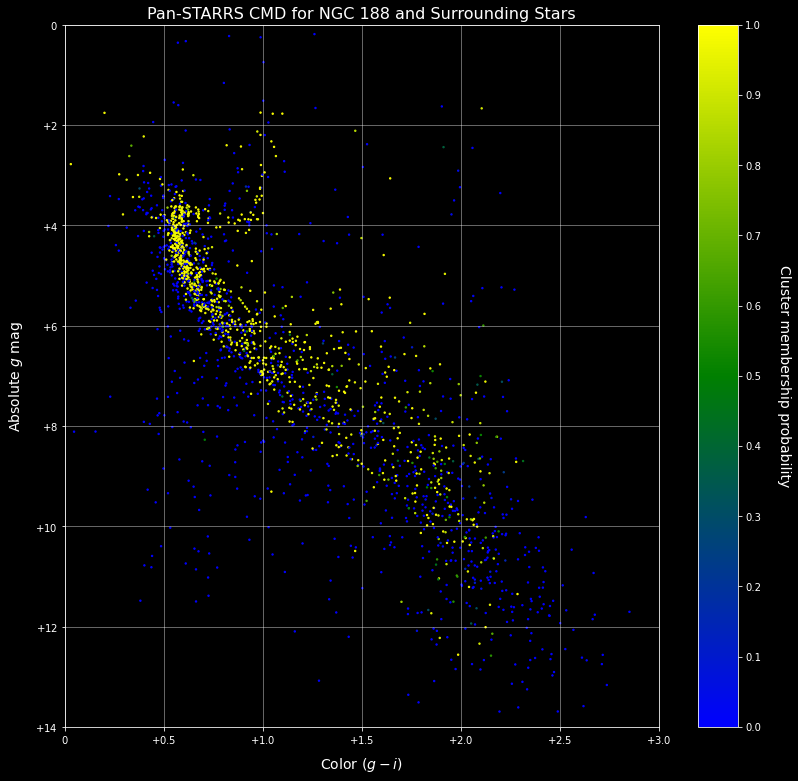

In [43]:
#only taking points that have 1 neighbor and 0 mates
results_df3 = results_df3[results_df3['number_of_neighbours'] == 1]
results_df3 = results_df3[results_df3['number_of_mates'] == 0]

#keeping only sources with ids that show up in our earlier query
results_df4 = pd.merge(results_df2[['source_id', 'prob']], results_df3, how='inner', on=['source_id'])

#calculating distance with parallax
dist4 = 1 / (results_df4['parallax'] * 0.001)

#using distance and apparent mag to calculate absolute mag
g_abs_p = results_df4['g_mean_psf_mag'] - (5 * (np.log10(dist4) - 1))
i_abs_p = results_df4['i_mean_psf_mag'] - (5 * (np.log10(dist4) - 1))

#setting up plot
fig = plt.figure(figsize=(11,13))
ax = fig.add_axes([0, 0, 0.75, 0.75])
ax.grid(alpha = 0.5)

#plotting data color-coded by probability
s = ax.scatter(g_abs_p - i_abs_p, g_abs_p, c = results_df4['prob'], s = 2, cmap = my_cmap1, norm = norm1)

#making plot look nice
plt.rcParams['axes.titlesize'] = 16
ax.set(title = 'Pan-STARRS CMD for NGC 188 and Surrounding Stars')
ax.set_ylim(14, 0)
ax.set_xlim(0, 3)
ax.set_xlabel(r'Color $(g - i)$', fontsize = 14, labelpad = 10)
ax.set_ylabel(r'Absolute $g$ mag', fontsize = 14, labelpad = 10)
ax.xaxis.set_major_formatter(xfmt)
ax.yaxis.set_major_formatter(yfmt)

#setting up and plotting our colorbar
colorbar_ax = fig.add_axes([0.8, 0, 0.05, 0.75])
fig.colorbar(s, cax = colorbar_ax)
colorbar_ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
colorbar_ax.set_ylabel('Cluster membership probability', labelpad = 30, rotation = 270, fontsize = 14);

In [34]:
#defining a new dataframe with only high probability cluster members
results_df5 = results_df4[results_df4['prob'] > 0.8]

#calculating distance for high probability members
dist5 = 1 / (results_df5['parallax'] * 0.001)

#calculating absolute mag for high probability members
g_abs_p = results_df5['g_mean_psf_mag'] - (5 * (np.log10(dist5) - 1))
i_abs_p = results_df5['i_mean_psf_mag'] - (5 * (np.log10(dist5) - 1))

#defining x and y data for our CMD, making them numpy arrays to prevent an error later
x_p = np.array(g_abs_p - i_abs_p)
y_p = np.array(g_abs_p)

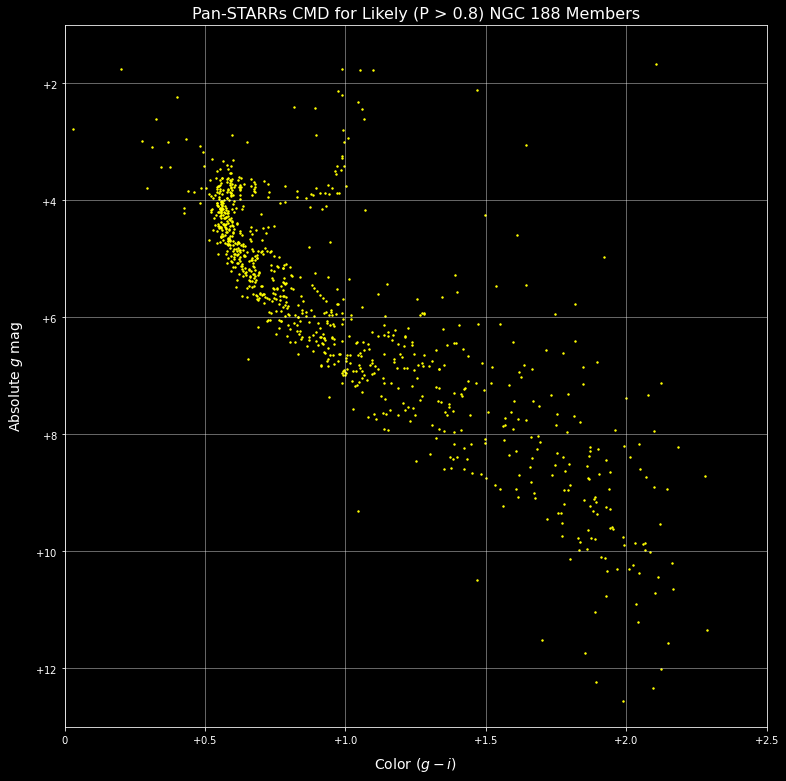

In [44]:
#setting up plot
fig = plt.figure(figsize=(13,13))
ax = fig.add_axes([0, 0, 0.75, 0.75])
ax.grid(alpha = 0.5)

#plotting high probability data
ax.scatter(x_p, y_p, c = 'yellow', s = 2, label = 'High-probability cluster member (P > 0.8)')

#making plot look nice
plt.rcParams['axes.titlesize'] = 16
ax.set(title = 'Pan-STARRs CMD for Likely (P > 0.8) NGC 188 Members')
ax.set_ylim(13, 1)
ax.set_xlim(0, 2.5)
ax.set_xlabel(r'Color $(g - i)$', fontsize = 14, labelpad = 10)
ax.set_ylabel(r'Absolute $g$ mag', fontsize = 14, labelpad = 10)
ax.xaxis.set_major_formatter(xfmt)
ax.yaxis.set_major_formatter(yfmt);

In [36]:
#same as last time
mask_y_l = y_p > 2
y_p_for_fit = y_p[mask_y_l]
x_p_for_fit = x_p[mask_y_l]
mask_y_u = y_p_for_fit < 6
y_p_for_fit = y_p_for_fit[mask_y_u]
x_p_for_fit = x_p_for_fit[mask_y_u]
mask_x_l = x_p_for_fit > 0
y_p_for_fit = y_p_for_fit[mask_x_l]
x_p_for_fit = x_p_for_fit[mask_x_l]
mask_x_u = x_p_for_fit < 2
y_p_for_fit = y_p_for_fit[mask_x_u]
x_p_for_fit = x_p_for_fit[mask_x_u]

#defining a function to find best age and metallicity parameters for an isochrone for our data
def objective(params):
    #defining parameters, getting our isochrone, defining more variables
    A, B = params
    r = parsec.get_one_isochrone(A, B, model = 'parsec12s', phot = 'panstarrs1', ret_table = True)
    gi = r['gP1'] - r['iP1']
    g = r['gP1']    
    
    #getting rid of less useful data again
    mask = g > 2
    g = g[mask]
    gi = gi[mask]    
    mask = g < 6
    g = g[mask]
    gi = gi[mask]
    mask = gi > 0
    g = g[mask]
    gi = gi[mask]
    mask = gi < 2
    g = g[mask]
    gi = gi[mask]

    #getting rid of duplicate indices so i can interpolate the model isochrone data
    unique_elements, indices = np.unique(gi, return_index = True)
    duplicate_indices = np.setdiff1d(np.arange(len(gi)), indices)
    gi = np.delete(gi, duplicate_indices)
    g = np.delete(g, duplicate_indices)

    #interpolating isochrone data so the length of the arrays are the same, so we can
    #subtract them from our actual data and get squared error
    spline = interp1d(gi, g, kind = 'nearest', bounds_error = False, fill_value = "extrapolate")
    gi_new = np.linspace(min(gi), max(gi), num = len(x_p_for_fit))
    g_new = spline(gi_new)
     
    #getting squared error as in difference from known data
    x_err = (x_p_for_fit - gi_new) ** 2
    y_err = (y_p_for_fit - g_new) ** 2
    return sum(x_err) + sum(y_err)

#defining initial guesses and bounds
initial_guess = [6.9e+09, 2.7e-02]
bounds = [(6e9, 7.5e9), (0.02, 0.035)]

#minimizing sum of squared error, printing our results
res2 = minimize(objective, initial_guess, method='powell', bounds=bounds, options={'xtol':1e-1, 'maxiter': 25})
print(res2.x)

#defining our optimal isochrone with our optimal parameters
r_p = parsec.get_one_isochrone(res2.x[0], res2.x[1], model = 'parsec12s', phot = 'panstarrs1', ret_table = True)

Interrogating http://stev.oapd.inaf.it...
Interrogating http://stev.oapd.inaf.it...
Interrogating http://stev.oapd.inaf.it...
Interrogating http://stev.oapd.inaf.it...
Interrogating http://stev.oapd.inaf.it...
Interrogating http://stev.oapd.inaf.it...
Interrogating http://stev.oapd.inaf.it...
Interrogating http://stev.oapd.inaf.it...
Interrogating http://stev.oapd.inaf.it...
Interrogating http://stev.oapd.inaf.it...
Interrogating http://stev.oapd.inaf.it...
Interrogating http://stev.oapd.inaf.it...
Interrogating http://stev.oapd.inaf.it...
Interrogating http://stev.oapd.inaf.it...
Interrogating http://stev.oapd.inaf.it...
Interrogating http://stev.oapd.inaf.it...
Interrogating http://stev.oapd.inaf.it...
Interrogating http://stev.oapd.inaf.it...
Interrogating http://stev.oapd.inaf.it...
Interrogating http://stev.oapd.inaf.it...
Interrogating http://stev.oapd.inaf.it...
Interrogating http://stev.oapd.inaf.it...
Interrogating http://stev.oapd.inaf.it...
Interrogating http://stev.oapd.ina

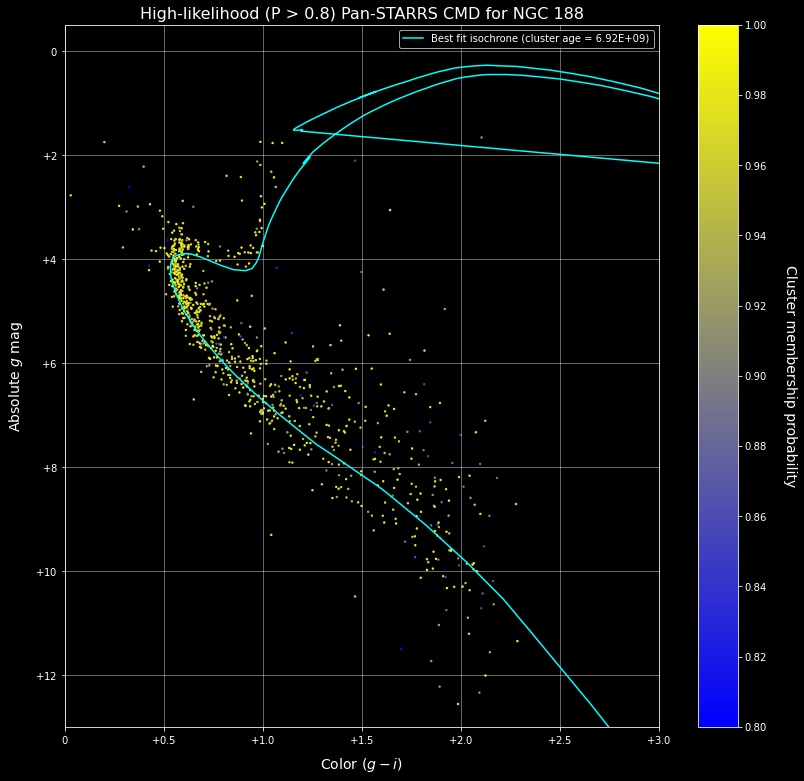

In [45]:
#defining fit data
x_p_fit = r_p['gP1'] - r_p['iP1']
y_p_fit = r_p['gP1']

#setting up our plot
fig = plt.figure(figsize=(11,13))
ax = fig.add_axes([0, 0, 0.75, 0.75])
ax.grid(alpha = 0.5)

#plotting our data, color coded by membership probability
s = ax.scatter(x_p, y_p, c = results_df5['prob'], s = 2, cmap = my_cmap80, norm = norm80)

#making plot look nice
plt.rcParams['axes.titlesize'] = 16
ax.set(title = 'High-likelihood (P > 0.8) Pan-STARRS CMD for NGC 188')
ax.set_ylim(13, -0.5)
ax.set_xlim(0, 3)
ax.set_xlabel(r'Color $(g - i)$', fontsize = 14, labelpad = 10)
ax.set_ylabel(r'Absolute $g$ mag', fontsize = 14, labelpad = 10)
ax.xaxis.set_major_formatter(xfmt)
ax.yaxis.set_major_formatter(yfmt)

#plotting our colorbar
colorbar_ax = fig.add_axes([0.8, 0, 0.05, 0.75])
fig.colorbar(s, cax = colorbar_ax)
colorbar_ax.set_yticks([0.80, 0.82, 0.84, 0.86, 0.88, 0.90, 0.92, 0.94, 0.96, 0.98, 1.0])
colorbar_ax.set_ylabel('Cluster membership probability', labelpad = 30, rotation = 270, fontsize = 14)

#plotting our fit
ax.plot(x_p_fit, y_p_fit, color = 'cyan', label = 'Best fit isochrone (cluster age = {age:.2E})'.format(age = res2.x[0]))
ax.legend();